# Libraries

The libraries listed below will be used in the execution of this project. Assisting us from data processing to prediction.

In [ ]:
# Install transfers to colab
!pip install transformers==4.37.2

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import pickle

# librosa to process audio files
import librosa as lb

import matplotlib.pyplot as plt

# Library to plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification

# sklearn class_weight calculator
from sklearn.utils import class_weight

# Libraries to build the model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, Masking, Dense, Input, MaxPooling1D, Flatten, Concatenate, BatchNormalization, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# BERT & Wav2Vec2
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoFeatureExtractor, TFWav2Vec2Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import the audio files

Load the audio files to the collab drive to be used during the audio model process




In [ ]:
# unpack zip file containing all IEMOCAP data
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/FP/NormalisedAudio.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Import the train, validation, and test dataframes

From the process previously written to extract, clean and convert all the information we are going to load each of the split dataframes. This will be used in this project to find the file locations, texts etc

In [ ]:
# import split dataframes
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/train_df_full.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/val_df_full.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FP/test_df_full.csv')

In [ ]:
# print the number of emotions that we see in the daframe
train_df.emotion_label.value_counts()

neutral       6394
angry         2129
joy           1799
sad           1656
frustrated    1478
surprise      1363
happy         1306
Name: emotion_label, dtype: int64

## Helper functions

The function below assists us in plotting the confusion matrix for analysis of the results

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(true_val, pred_val, classes, title = 'Confusion Matrix'):
    """
        This function plots the confusion matrix
        true_val: True labels
        pred_val: Predicted labels
        classes: List of classes
    """
    # build and plot the confusion matrix with the true and predicted values
    cm = confusion_matrix(true_val, pred_val, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    # plot size
    plt.size=(6,6)
    # set title
    plt.title(title)
    plt.show()

Function to pickle variables and save them to the disk, which can be loaded later for future use.

In [ ]:
def save_object(obj, filename):
    """
        This function saves the object to a pickle file
        obj: Object to save
        filename: Output file pathname
    """
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
  """
      This function loads the object from a pickle file
      filename: Input file path to load
  """
  with open(filename, 'rb') as fp:
    data = pickle.load(fp)
  return data

## Create the emotion dict, list and length

This information will support the development of the models over the next few cells.

In [ ]:
# create a dictionary with the emotion_num and emotion_label
emotion_dict = dict(sorted(zip(train_df.emotion_num, train_df.emotion_label)))
num_emo_dict = {y: x for x, y in emotion_dict.items()}

print(emotion_dict)
print(num_emo_dict)

{0: 'neutral', 1: 'angry', 2: 'joy', 3: 'sad', 4: 'frustrated', 5: 'surprise', 6: 'happy'}
{'neutral': 0, 'angry': 1, 'joy': 2, 'sad': 3, 'frustrated': 4, 'surprise': 5, 'happy': 6}


In [ ]:
# Create label list for the confusion matrix
labels_list = list(emotion_dict.values())
print(labels_list)

['neutral', 'angry', 'joy', 'sad', 'frustrated', 'surprise', 'happy']


In [ ]:
# Let's print the labels length
len_labels = len(labels_list)
len_labels

7

# Text Pre-processing

## Tokenization for text classification

Machine learning models cannot simply read the text as is, hence text must be transformed into a model-compatible format, therefore words must be tokenized, which is a process that translates words to a numerical representation. For this project it will be used the BERT Tokenizer, which was pre-trained on a large corpus of text data.

In [ ]:
# Create the tokenizer object using the BERT vocab bert-base-uncased file
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Tokenizer vocab_size
vocab_size = len(tokenizer.vocab)
print(f'Vocab size: {vocab_size}')

Vocab size: 30522


In [ ]:
# Function to tokenize the sentences using the BERT tokenizer
def bert_tokenizer(sentence, labels_val, max_len):
    """
        Perform required preprocessing steps for pretrained BERT.
        sentence: Sentence to tokenize
        labels: List of labels to be encoded
        max_len: Max length of the sentence (truncating point/padding point)
        return: Tokenized sentence
    """

    # Initialise lists to store outputs
    input_ids = []
    attention_masks = []

    # Iterate through each sentence and encode them
    # https://huggingface.co/transformers/v2.11.0/_modules/transformers/tokenization_utils.html#PreTrainedTokenizer.encode_plus
    # encode_plus method ^^
    for sent in sentence:
        try:
            encoded_sent = tokenizer.encode_plus(
                text = sent,                    # Sentence to encode
                add_special_tokens = True,      # [CLS] and [SEP] tokens
                max_length = max_len,           # Max length
                padding = 'max_length',         # Pad sentence to max length
                truncation = True,              # Truncate if longer than max length
                return_attention_mask = True    # Return attention mask
                )
        except:
            # print the sentence that caused the error and the error itself
            print(f'Error with sentence: {sent}')
            break

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to numpy arrays for training/prediction
    input_ids = np.array(input_ids, dtype='int64')
    attention_masks = np.array(attention_masks, dtype='int64')
    labels = np.array(labels_val, dtype='int64')

    return input_ids, attention_masks, labels

Execute the tokenization to all datasets using the bert_tokenizer function.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16125 entries, 0 to 16124
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   dataset            16125 non-null  object
 1   filename           16125 non-null  object
 2   filepath           16125 non-null  object
 3   transcription      16125 non-null  object
 4   emotion_label      16125 non-null  object
 5   clean_text         16125 non-null  object
 6   emotion_num        16125 non-null  int64 
 7   nr_filepath        16125 non-null  object
 8   asr_transcription  16125 non-null  object
 9   asr_clean_text     16125 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [ ]:
# Set the maximum length of the sentences to pad/truncate
max_len = 180

# Tokenize the train, validation and test sets
train_inputs, train_masks, train_labels = bert_tokenizer(train_df['clean_text'], train_df['emotion_num'], max_len)
val_inputs, val_masks, val_labels = bert_tokenizer(val_df['clean_text'],  val_df['emotion_num'], max_len)
test_inputs, test_masks, test_labels = bert_tokenizer(test_df['clean_text'], test_df['emotion_num'], max_len)

In [ ]:
# Tokenize the train, validation and test sets
train_inputs_asr, train_masks_asr, train_labels = bert_tokenizer(train_df['asr_clean_text'], train_df['emotion_num'], max_len)
val_inputs_asr, val_masks_asr, val_labels = bert_tokenizer(val_df['asr_clean_text'],  val_df['emotion_num'], max_len)
test_inputs_asr, test_masks_asr, test_labels = bert_tokenizer(test_df['asr_clean_text'], test_df['emotion_num'], max_len)

In [ ]:
# Print the shapes of the inputs
print(f'Train input_ids shape: {train_inputs.shape}')
print(f'Train train_labels shape: {train_labels.shape}')

print(f'Validation input_ids shape: {val_inputs.shape}')
print(f'Validation val_labels shape: {val_labels.shape}')

print(f'Test input_ids shape: {test_inputs.shape}')
print(f'Test test_labels shape: {test_labels.shape}')

Train input_ids shape: (16125, 180)
Train train_labels shape: (16125,)
Validation input_ids shape: (2016, 180)
Validation val_labels shape: (2016,)
Test input_ids shape: (2016, 180)
Test test_labels shape: (2016,)


Printing an example of a tokenized sentence

In [ ]:
# Print the original train input sentence and its tokenized ids
rand = np.random.randint(0, train_inputs.shape[0])

print(f'Original sentence: {train_df.transcription.iloc[rand]}')
print(f'Clean train sentence: {train_df.clean_text.iloc[rand]}')
print(f'Token ids of train sentence: {train_inputs[rand]}')
print(f'Decoded train sentence: {tokenizer.decode(train_inputs[rand])}')

Original sentence: Twice is every time we've tried that's ever.
Clean train sentence: twice be every time we have try that be ever .
Token ids of train sentence: [ 101 3807 2022 2296 2051 2057 2031 3046 2008 2022 2412 1012  102    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  

# Audio Pre-processing

## Conv1D Audio Pre-processing

The function extract_features_1d was developed to extract the MFCC, ZCR, Chroma, RMS and Mel features in frequency bin format, which are stacked together and the mean is applied to reduce the dimensionality of the features while preserving all the essential information.


In [ ]:
def extract_features_1d(path: str):
    """
        Extract the audio features (MFCC, ZCR, Chroma, RMS and MelSpectrogram) from the audio file
        path: Path to the audio file to extract features from
        return: Stacked audio features
    """
    # extract the audio data and sample rate
    audio, sr = lb.load(path)

    # Store the results
    result = np.array([])

    # MFCC
    mfcc = np.mean(lb.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512))
    result = np.hstack((result, mfcc)) # stacking horizontally

    # ZCR
    zcr = np.mean(lb.feature.zero_crossing_rate(y=audio).T, axis=0)
    result = np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(lb.stft(audio))
    chroma_stft = np.mean(lb.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(lb.feature.rms(y=audio).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(lb.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [ ]:
def load_data_1d(df, filepath_col, emotion_col):
    """
        Function used to drive the data loading and feature extraction process
        df: Dataframe
        return: X, y
    """
    X = []

    # iterate through each file and extract the features
    for file in df[filepath_col]:
        feature=extract_features_1d(file)
        X.append(feature)

    # convert X to numpy array and reshape
    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    # convert Y to numpy array
    y_list = df[emotion_col].to_list()
    y = np.array(y_list,dtype='int64')

    return X,y

In [ ]:
# Load the data
X_train_1d, y_train_1d = load_data_1d(train_df, 'nr_filepath', 'emotion_num')
X_val_1d, y_val_1d = load_data_1d(val_df, 'nr_filepath', 'emotion_num')
X_test_1d, y_test_1d = load_data_1d(test_df, 'nr_filepath', 'emotion_num')

In [ ]:
# save the 1D objects using pickle to avoid re-running the code
save_object(X_train_1d, '/content/drive/MyDrive/pickle/X_train_1d.pkl')
save_object(y_train_1d, '/content/drive/MyDrive/pickle/y_train_1d.pkl')

save_object(X_val_1d, '/content/drive/MyDrive/pickle/X_val_1d.pkl')
save_object(y_val_1d, '/content/drive/MyDrive/pickle/y_val_1d.pkl')

save_object(X_test_1d, '/content/drive/MyDrive/pickle/X_test_1d.pkl')
save_object(y_test_1d, '/content/drive/MyDrive/pickle/y_test_1d.pkl')

In [ ]:
# When re-running the code, we can load the objects using pickle
X_train_1d = load_object('/content/drive/MyDrive/pickle/X_train_1d.pkl')
y_train_1d = load_object('/content/drive/MyDrive/pickle/y_train_1d.pkl')

X_val_1d = load_object('/content/drive/MyDrive/pickle/X_val_1d.pkl')
y_val_1d = load_object('/content/drive/MyDrive/pickle/y_val_1d.pkl')

X_test_1d = load_object('/content/drive/MyDrive/pickle/X_test_1d.pkl')
y_test_1d = load_object('/content/drive/MyDrive/pickle/y_test_1d.pkl')


In [ ]:
# Print the shapes of the 1D inputs which will be used for the 1D CNN model. It should have the format (samples, features, 1)
X_train_1d.shape, y_train_1d.shape, X_val_1d.shape, y_val_1d.shape,  X_test_1d.shape, y_test_1d.shape

((16125, 143, 1), (16125,), (2016, 143, 1), (2016,), (2016, 143, 1), (2016,))

## Conv2D Audio Pre-processing

The function extract_audio_features_2d was developed to extract the same audio features from audio files, which include the batch size, frequency bins and channel representations. The standardise function, calculates the standard deviation and mean values, followed by subtracting the mean from each feature and dividing by the standard deviation which generates a value between 0 and 1, ensuring consistent scales, that consequently mitigates bias in the learning process.

In [ ]:
def standardise(features):
    """
        Standardise the features by subtracting the mean and dividing by the standard deviation resulting in value between 0 and 1.
        features: Features to standardise
        return: Standardised features
    """
    # calculate the standard dev
    std = np.std(features, axis=0)
    std[std == 0] = 1e-10 # handle division by zero by replacing it with small val
    mean = features.mean(axis=0)
    features = (features - mean) / std

    return features

In [ ]:
def extract_audio_features_2d(file_path):
    """
        Extract MFCC, ZCR, Chroma, RMS and mel features from the audio files.
        file_path: Path to the audio file to extract features from
        return: 2D numpy array of features
    """

    # Extract features
    audio, sr = lb.load(file_path)

    # MFCC
    mfcc = lb.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)

    # Zero-crossing rate
    zcr = lb.feature.zero_crossing_rate(y=audio)

    # Chroma_stft
    stft  = np.abs(lb.stft(audio))
    chroma = lb.feature.chroma_stft(S=stft, sr=sr)

    # RMS
    rms = lb.feature.rms(y=audio)

    # MelSpectogram
    mel = lb.feature.melspectrogram(y=audio, sr=sr)

    # Combine features into a 2D array
    # Transpose the values making rows the features and columns the observations
    features = np.vstack([mfcc, zcr, chroma, rms, mel]).T
    features = standardise(features)

    # Reshape the features to match the format for the CNN
    features = features.reshape(1, features.shape[0], features.shape[1], 1)

    return features

The results are padded or truncated to maintain consistency accross the lenght sizes

In [ ]:
# pad the longest feature length
def pad_features(features):
    """
        Pad the features to have a consistent length
        features: List of features to pad
        return: Padded features
    """
    # set the max length of features to 400
    max_length = 400

    #iterate over the features list and pad if the length is less than the max length else truncate to the max length
    for i in range(len(features)):
        if features[i].shape[1] < max_length:
            features[i] = np.pad(features[i], ((0, 0), (0, max_length - features[i].shape[1]), (0, 0), (0, 0)), mode='constant')
        else:
            features[i] = features[i][:, :max_length, :, :]

    return features

Iterate over the files and return the encoded values and their respective labels

In [ ]:
def load_data_2d(df, filepath_col, emotion_col):
    """
        Load the data and extract the features
        df: Dataframe
        return: X, y
    """
    X = []

    # iterate over the file paths to extract the features
    for file in df[filepath_col]:
        feature=extract_audio_features_2d(file)
        X.append(feature)

    # pad the features
    X = pad_features(X)

    # Combine features from all files into a single NumPy array
    X = np.concatenate(X, axis=0)

    # convert df num_label to list and then to numpy array
    y = df[emotion_col].to_list()
    y = np.array(y,dtype='int64')

    return X,y

In [ ]:
# load the data for the train, val and test sets
X_train_2d, y_train_2d = load_data_2d(train_df, 'nr_filepath', 'emotion_num')
X_val_2d, y_val_2d = load_data_2d(val_df, 'nr_filepath', 'emotion_num')
X_test_2d, y_test_2d = load_data_2d(test_df, 'nr_filepath', 'emotion_num')

In [ ]:
# save the objects using pickle to avoid re-running the code
save_object(X_train_2d, '/content/drive/MyDrive/pickle/X_train_2d.pkl')
save_object(y_train_2d, '/content/drive/MyDrive/pickle/y_train_2d.pkl')

save_object(X_val_2d, '/content/drive/MyDrive/pickle/X_val_2d.pkl')
save_object(y_val_2d, '/content/drive/MyDrive/pickle/y_val_2d.pkl')

save_object(X_test_2d, '/content/drive/MyDrive/pickle/X_test_2d.pkl')
save_object(y_test_2d, '/content/drive/MyDrive/pickle/y_test_2d.pkl')

In [ ]:
# When re-running the code, we can load the objects using pickle
X_train_2d = load_object('/content/drive/MyDrive/pickle/X_train_2d.pkl')
y_train_2d = load_object('/content/drive/MyDrive/pickle/y_train_2d.pkl')

X_val_2d = load_object('/content/drive/MyDrive/pickle/X_val_2d.pkl')
y_val_2d = load_object('/content/drive/MyDrive/pickle/y_val_2d.pkl')

X_test_2d = load_object('/content/drive/MyDrive/pickle/X_test_2d.pkl')
y_test_2d = load_object('/content/drive/MyDrive/pickle/y_test_2d.pkl')

When verifying the shape for the 2D data we should see:

X values should have 4 dimensions \
y values should have 1 dimension

In [ ]:
# print the shape of the data
X_train_2d.shape, y_train_2d.shape, X_val_2d.shape, y_val_2d.shape, X_test_2d.shape, y_test_2d.shape

((16125, 400, 162, 1),
 (16125,),
 (2016, 400, 162, 1),
 (2016,),
 (2016, 400, 162, 1),
 (2016,))

## Wav2Vec2 Audio Pre-processing

Similarly to the pre-processing for the other models, Wav2Vec2 requires the audio features to be extracted. However, instead of extracting the raw audio features using Librosa we need to utilise the "AutoFeatureExtractor" and extract the features using the pre-trained configuration from wav2vec2-base, resulting in an array of features that are accepted by the pre-trained model.

In [ ]:
sampling_rate = 16000 # Audio sampling rate
hidden_dim = 768  # Model output dimensionality
max_seq_len = 5 * sampling_rate  # Maximum length of the input audio file.
seq_len = (max_seq_len // 320)-1 # Calculate the stride of the model - 320 is the default
wav2vec2_pretrained = "facebook/wav2vec2-base"  # Pretrained model from Hugging Face to load

In [ ]:
# Load the model feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(
    wav2vec2_pretrained, return_attention_mask=True
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [ ]:
def preprocess_wav2vec2(feature_extractor, audio_files, target_sampling_rate, labels_val, max_seq_len):
    """
        This function takes in an audio file and processes it to return the input_ids and attention_mask features
        audio_file: Path to the audio file
        processor: Wav2Vec2 processor
        target_sampling_rate: The target sampling rate
    """
    # Initialise lists to store outputs
    input_features = []
    attention_masks = []

    # Loop through the audio files and extract the features using the Wav2Vec2 feature_extractor
    for file in audio_files:
      # load the audio data, set the sampling rate to 16kHz
      audio, sr = lb.load(file)
      audio = np.squeeze(audio)
      audio = lb.resample(audio, orig_sr=sr, target_sr=target_sampling_rate)

      try:
        result = feature_extractor(
                        audio,
                        sampling_rate=target_sampling_rate,
                        max_length=max_seq_len,
                        padding='max_length',
                        truncation=True
            )
      except:
        print(f'Error processing file: {file}')
        break

      # Add the outputs to the lists
      input_features.append(result.get('input_values'))
      attention_masks.append(result.get('attention_mask'))

    # Add the outputs to the lists
    input_features =  np.array(input_features, dtype='float32').squeeze()
    attention_masks = np.array(attention_masks, dtype='int32').squeeze()
    labels = np.array(labels_val, dtype='int32')

    return input_features, attention_masks, labels

In [ ]:
# Tokenize the train, validation and test sets
w2v2_train_features, w2v2_train_masks, w2v2_train_y = preprocess_wav2vec2(feature_extractor, train_df['nr_filepath'], sampling_rate, train_df['emotion_num'], max_seq_len)
w2v2_val_features, w2v2_val_masks, w2v2_val_y = preprocess_wav2vec2(feature_extractor, val_df['nr_filepath'], sampling_rate, val_df['emotion_num'], max_seq_len)
w2v2_test_features, w2v2_test_masks, w2v2_test_y = preprocess_wav2vec2(feature_extractor, test_df['nr_filepath'], sampling_rate, test_df['emotion_num'], max_seq_len)

In [ ]:
# Create the input dictionaries
w2v2_train_x = { "input_features": w2v2_train_features, "attention_mask": w2v2_train_masks}
w2v2_val_x = { "input_features": w2v2_val_features, "attention_mask": w2v2_val_masks}
w2v2_test_x = { "input_features": w2v2_test_features, "attention_mask": w2v2_test_masks}

# Compute class weights

The compute_class_weight function from scikit-learn helps to address the class imbalance issue by determining weights for each class. The weights are porportionate to the class frequency, with minority classes receiving larger weights. These weights can assist the models to pay more attention to lower classes, lowering bias towards the dominant class.



In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.3602707895795165,
 1: 1.0819969133731464,
 2: 1.2804732788056856,
 3: 1.3910455486542443,
 4: 1.5585733616856756,
 5: 1.690074415679698,
 6: 1.763837234740757}

# Baseline model

To evaluate the model and create a base for comparison it will be used a well-defined CNN Keras sequential models using Conv1D convolutional neural network (CNN) for text and audio classification developed to capture local patterns and relationships in sequential input data.

## Text model (TextCNN)

The baseline text model employs three Conv1D layers, starting with 256 filters and progressively reducing to 64, which includes the kernel sizes (3-5) reflecting the size of the n-grams sequence feature to read at a time. Furthermore, it utilises ReLU activation and GlobalMaxPooling1D to reduce dimensionality of the feature map. To improve regularisation and prevent overfitting, two dropout layers of 0.5 are also applied. Finally, a Dense layer with softmax to output the predicted values. This architecture leverages CNNs to learn from sequential text data for task-specific predictions.


In [ ]:
textcnn_model = Sequential([
    Embedding(vocab_size, 256, input_length=max_len),
    Masking(mask_value=0.0), # Masking layer to handle the padded values
    # 1st Conv1D layer with kernel size 3 and relu activation
    Conv1D(256, kernel_size=3, activation='relu'),
    # 2nd Conv1D layer with kernel size 4 and relu activation
    Conv1D(128, kernel_size=4, activation='relu'),
    Dropout(0.2), # Dropout layer to reduce overfitting
    # 3rd Conv1D layer with kernel size 4 and relu activation
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(), # Pooling for feature extraction
    Dropout(0.5), # Dropout layer to reduce overfitting
    Dense(32, activation='relu'), # Dense layer with ReLU
    Dense(len_labels, activation='softmax') # Softmax output layer
],name='BaselineTextCNN')

# Compile the model and include Adam optimizer
textcnn_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001, epsilon=2e-08),
        metrics=['accuracy']
)

# Print the model summary
textcnn_model.summary()

Model: "BaselineTextCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 256)          7813632   
                                                                 
 masking (Masking)           (None, 180, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 178, 256)          196864    
                                                                 
 conv1d_1 (Conv1D)           (None, 175, 128)          131200    
                                                                 
 dropout (Dropout)           (None, 175, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 171, 64)           41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)            

In [ ]:
# Train the model
h_text_cnn = textcnn_model.fit(
    train_inputs,
    train_labels,
    batch_size=16,
    epochs=10,
    validation_data=(val_inputs, val_labels),
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 18s 25ms/step - loss: 1.7701 - accuracy: 0.3929 - val_loss: 1.7237 - val_accuracy: 0.4256 - lr: 1.0000e-04
Epoch 2/10
504/504 [==============================] - 5s 10ms/step - loss: 1.6684 - accuracy: 0.4287 - val_loss: 1.5990 - val_accuracy: 0.4435 - lr: 1.0000e-04
Epoch 3/10
504/504 [==============================] - 3s 7ms/step - loss: 1.5986 - accuracy: 0.4399 - val_loss: 1.5595 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 4/10
504/504 [==============================] - 3s 7ms/step - loss: 1.5058 - accuracy: 0.4649 - val_loss: 1.4994 - val_accuracy: 0.4762 - lr: 1.0000e-04
Epoch 5/10
504/504 [==============================] - 3s 7ms/step - loss: 1.4271 - accuracy: 0.4900 - val_loss: 1.4629 - val_accuracy: 0.4901 - lr: 1.0000e-04
Epoch 6/10
504/504 [==============================] - 3s 6ms/step - loss: 1.3511 - accuracy: 0.5197 - val_loss: 1.4420 - val_accuracy: 0.4886 - lr: 1.0000e-04
Epoch 7/10
504/504 [=======================

In [ ]:
# Predict the results using the test inputs
y_pred_textcnn = textcnn_model.predict(test_inputs)
y_pred_textcnn = np.argmax(y_pred_textcnn, axis=1)

# print the model performance
print(classification_report(test_labels, y_pred_textcnn, target_names=labels_list, zero_division=1))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     neutral       0.64      0.70      0.67       799
       angry       0.47      0.29      0.36       266
         joy       0.40      0.47      0.43       225
         sad       0.36      0.22      0.27       207
  frustrated       0.38      0.48      0.43       185
    surprise       0.49      0.59      0.53       170
       happy       0.56      0.53      0.54       164

    accuracy                           0.53      2016
   macro avg       0.47      0.47      0.46      2016
weighted avg       0.52      0.53      0.52      2016



In [ ]:
textcnn_model.save_weights('/content/drive/MyDrive/SavedModelWeights/textcnn_model_weight4.keras')

In [ ]:
textcnn_model.load_weights('/content/drive/MyDrive/SavedModelWeights/textcnn_model_weight4.keras')

## Conv1D Audio Model

The baseline audio emotion aligns with established practices in audio classification due to its effectiveness in extracting relevant features from audio signals. The model is comprised of four Conv1D layers, starting with 256 filters and progressively reducing to 64. Each layer utilises a kernel size of 5 with ReLU activation for non-linearity. Subsequently, to each Conv1D layer, a MaxPooling1D was added to reduce the dimensionality of feature maps. Similarly to the text model, two dropout layers of 0.5 are used. Finally, the output layer uses a softmax activation function to get the final emotion categorization probabilities.

In [ ]:
audio_conv1d_base_model = Sequential([
    # initial layer with input shape
    Conv1D(256, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_1d.shape[1], 1)),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # Conv1D layer with 256 filters and relu activation and maxpooling to reduce the feature maps
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # Conv2D layer with 128 filters and relu activation
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # Conv2D layer with 64 filters and relu activation
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dense(32, activation='relu'),
    Dropout(0.5), # Dropout layer to reduce overfitting
    Dense(len_labels, activation='softmax') # Output layer
], name='BaselineAudioConv1D')

# Compile the model
audio_conv1d_base_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

audio_conv1d_base_model.summary()


Model: "BaselineAudioConv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 143, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 256)           0         
 D)                                                              
                                                                 
 conv1d_4 (Conv1D)           (None, 29, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 256)            0         
 g1D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 6, 256)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 128)    

In [ ]:
# Train the model
h_audio_base = audio_conv1d_base_model.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 6s 6ms/step - loss: 2.0085 - accuracy: 0.2940 - val_loss: 1.8228 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 2s 5ms/step - loss: 1.8644 - accuracy: 0.3619 - val_loss: 1.7856 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 2s 5ms/step - loss: 1.8321 - accuracy: 0.3755 - val_loss: 1.7696 - val_accuracy: 0.3973 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 2s 5ms/step - loss: 1.8243 - accuracy: 0.3788 - val_loss: 1.7543 - val_accuracy: 0.3973 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 3s 5ms/step - loss: 1.8137 - accuracy: 0.3839 - val_loss: 1.7607 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 3s 5ms/step - loss: 1.8006 - accuracy: 0.3834 - val_loss: 1.7374 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 7/10
504/504 [==========================

In [ ]:
# Predict the results using the unseen test inputs
y_pred_base_audio = audio_conv1d_base_model.predict(X_test_1d)
y_pred_base_audio = np.argmax(y_pred_base_audio, axis=1)

# print the model performance
print(classification_report(y_test_1d, y_pred_base_audio, target_names=labels_list, zero_division=0))

In [ ]:
audio_conv1d_base_model.save('/content/drive/MyDrive/SavedModelWeights/audio_conv1d_base_model.keras')

In [ ]:
audio_conv1d_base_model.load_weights('/content/drive/MyDrive/SavedModelWeights/audio_conv1d_base_model.keras')

# Further development models

In this section, we will analyse several models with different architectures, train them, and compare their performance to baseline models to determine the most effective ones.

### BERT Pre-Trained Model

The BERT model was built using a pre-trained model that is widely known in the NLP industry for its proven effectiveness. TFBertForSequenceClassification was used for the implementation, it combines BERT with a sequence classification head, ideal for text analysis. The 'bert-base-uncased' was used for transfer learning, pre-trained on BookCorpus and English Wikipedia. Training included the inputs, attention masks, and a dropout (0.5) to prevent overfitting. The final layer utilizes softmax activation to output projections.

In [ ]:
bert_pretrained = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',          # 12-layer BERT model uncased vocab.
    num_labels = len_labels)      # The number of output labels

In [ ]:
def build_bert_model(bert_model, shape_size):
    """
        This function builds the BERT Text model
        bert_model: BERT pretrained model
        shape_size: Shape size of the input
        return: BERT model
    """
    input_ids = Input(shape=(shape_size,), dtype=tf.int32, name='input_ids') # input ids layer
    attention_masks = Input(shape=(shape_size,), dtype=tf.int32, name='attention_masks') # attention masks layer

    bert_output = bert_model(input_ids, attention_masks)[0] # Output of the BERT model last hidden state
    output = Dropout(0.5)(bert_output) # Dropout layer to reduce overfitting
    output = Dense(len_labels, activation='softmax')(output) # Dense layer for classification
    model = Model(inputs = [input_ids, attention_masks],outputs = output, name='BERTModel')

    return model

# Build the BERT model
bert_model = build_bert_model(bert_pretrained, max_len)

# Compile the model
bert_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

bert_model.summary()

Model: "BERTModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 180)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094876   ['input_ids[0][0]',           
 ification (TFBertForSequen  (loss=None, logits=(None,    23         'attention_masks[0][0]']     
 ceClassification)           7),                                                          

In [ ]:
h_bert = bert_model.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_data=([val_inputs, val_masks], val_labels),
    epochs=4,
    class_weight=class_weight_dict,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
1008/1008 [==============================] - 265s 219ms/step - loss: 1.6913 - accuracy: 0.2800 - val_loss: 1.4989 - val_accuracy: 0.4772 - lr: 2.0000e-05
Epoch 2/4
1008/1008 [==============================] - 217s 215ms/step - loss: 1.4567 - accuracy: 0.4607 - val_loss: 1.4003 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 3/4
1008/1008 [==============================] - 217s 215ms/step - loss: 1.2640 - accuracy: 0.5669 - val_loss: 1.3223 - val_accuracy: 0.5615 - lr: 2.0000e-05
Epoch 4/4
1008/1008 [==============================] - 217s 216ms/step - loss: 1.1144 - accuracy: 0.5635 - val_loss: 1.3596 - val_accuracy: 0.5756 - lr: 2.0000e-05


In [ ]:
# Predict the results using the unseen test inputs
y_pred_bert = bert_model.predict([test_inputs, test_masks])
y_pred_bert = np.argmax(y_pred_bert, axis=1)

# print the model performance
print(classification_report(test_labels, y_pred_bert, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 10s 112ms/step
              precision    recall  f1-score   support

     neutral       0.36      0.04      0.07       799
       angry       0.28      0.55      0.37       266
         joy       0.57      0.07      0.13       225
         sad       0.08      0.00      0.01       207
  frustrated       0.25      0.61      0.36       185
    surprise       0.03      0.14      0.04       170
       happy       0.87      0.12      0.21       164

    accuracy                           0.17      2016
   macro avg       0.35      0.22      0.17      2016
weighted avg       0.35      0.17      0.15      2016



In [ ]:
bert_model.save_weights('/content/drive/MyDrive/SavedModelWeights/bert_model_FP_weighted2.keras')

In [ ]:
bert_model.load_weights('/content/drive/MyDrive/SavedModelWeights/bert_model_FP_weighted2.keras')

# Conv1D Models

## Conv1D with BatchNormalisation

Another version of the Conv1D CNN models utilises BatchNormalization. This technique normalises the activations of each layer to create a constant mean and variance. This consequently leads to more stable gradients allowing the model to learn faster and converge effectively, improving the model’s generalisation capabilities. Furthermore, Batch Normalization acts as a regulariser, preventing overfitting. The model uses a keras sequential model, consisting of 5 Conv1D layers, starting with 512 filters and progressively decreasing to 64. Following each Conv1D layer it was added BatchNormalization layers to normalise the outputs, followed by MaxPooling1D layers with a pool size of 5 to reduce the dimensionality of the feature maps. Finally, the results are flattened, and the output layer utilising a softmax returns the values, similarly to the previous architectures.

In [ ]:

cnn_batchnorm = Sequential([
    # 1st Conv1D layer with kernel size 5 and relu activation
    Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train_1d.shape[1],1)),
    BatchNormalization(), # Batch normalization layer to normalise the input
    MaxPooling1D(pool_size=5,strides=2,padding='same'), # Maxpooling layer to reduce the feature maps
    # 2nd Conv1D layer with kernel size 4 and relu activation
    Conv1D(512,kernel_size=4,strides=1,padding='same',activation='relu'),
    BatchNormalization(), # Batch normalization layer to normalise the input
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 3rd Conv1D layer with kernel size 3 and relu activation
    Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 4th Conv1D layer with kernel size 2 and relu activation
    Conv1D(128,kernel_size=2,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5,strides=2,padding='same'),
    # 5th Conv1D layer with kernel size 2 and relu activation
    Conv1D(64,kernel_size=2,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Flatten(), # Flatten layer to convert 2D to 1D
    # Dense layer with 64 neurons and relu activation
    Dense(64,activation='relu'),
    BatchNormalization(), # normalise the values
    Dense(len_labels,activation='softmax') # Output layer
])

cnn_batchnorm.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

cnn_batchnorm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 512)          3072      
                                                                 
 batch_normalization (Batch  (None, 143, 512)          2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 72, 512)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 512)           1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 72, 512)           2048      
 chNormalization)                                                
                                                        

In [ ]:
# Train the model
h_cnn_batchnorm = cnn_batchnorm.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=10,
    class_weight=class_weight_dict,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 6s 11ms/step - loss: 1.5747 - accuracy: 0.4101 - val_loss: 1.7419 - val_accuracy: 0.3755 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 5s 11ms/step - loss: 1.5535 - accuracy: 0.4265 - val_loss: 1.7502 - val_accuracy: 0.3938 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 5s 10ms/step - loss: 1.5416 - accuracy: 0.4254 - val_loss: 1.9219 - val_accuracy: 0.2842 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 5s 10ms/step - loss: 1.5203 - accuracy: 0.4336 - val_loss: 1.7138 - val_accuracy: 0.3775 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 5s 11ms/step - loss: 1.5001 - accuracy: 0.4424 - val_loss: 1.7814 - val_accuracy: 0.3700 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 6s 11ms/step - loss: 1.4821 - accuracy: 0.4523 - val_loss: 1.6869 - val_accuracy: 0.4038 - lr: 2.0000e-05
Epoch 7/10
504/504 [====================

In [ ]:
# predict on test data
y_pred_batch = cnn_batchnorm.predict(X_test_1d)

# convert predictions
y_pred_batch = np.argmax(y_pred_batch, axis=1)

# print the index to class and the algorithm performance
print(classification_report(y_test_1d, y_pred_batch, target_names=labels_list, zero_division=1))

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     neutral       0.51      0.66      0.57       799
       angry       0.27      0.38      0.31       266
         joy       0.20      0.14      0.17       225
         sad       0.55      0.24      0.34       207
  frustrated       0.30      0.42      0.35       185
    surprise       0.26      0.04      0.06       170
       happy       0.38      0.16      0.22       164

    accuracy                           0.41      2016
   macro avg       0.35      0.29      0.29      2016
weighted avg       0.40      0.41      0.38      2016



In [ ]:
cnn_batchnorm.save('/content/drive/MyDrive/SavedModelWeights/cnn_batchnorm.keras')

In [ ]:
cnn_batchnorm.load_weights('/content/drive/MyDrive/SavedModelWeights/cnn_batchnorm.keras')

## Conv1D with Bi-LSTM

Utilising Bidirectional-LSTM has several advantages, as this type of recurrent neural network (RNN) can be used to learn long-term dependencies between time steps or sequential data. Its bidirectional functionality allows the layer to process the input features forward and backwards simultaneously; the layers are then integrated to produce a richer representation of the data patterns and relationships. This model contains two Conv1D layers with filter sizes of 256 and utilises ReLU activation and MaxPooling1D. Two Bi-LSTM layers are then added to the keras sequential model with filter sizes of 128 and 64, respectively. Two dropouts of 0.5 and 0.3 have also been added to reduce overfitting of the algorithm; finally, a softmax layer to generate output results.

In [ ]:
conv1d_lstm_model = Sequential([
    # initial layer with input shape and relu activation
    Conv1D(256, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_1d.shape[1], 1)),
    MaxPooling1D(pool_size=5, padding = 'same'), # Maxpooling layer to reduce the feature maps
    # Conv1D layer with 256 filters and relu activation and maxpooling to downsample the feature maps
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=5, padding = 'same'),
    # 1st BiLSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # 2nd BiLSTM layer
    Bidirectional(LSTM(64, return_sequences=True)),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dense(32, activation='relu'), # Dense layer with ReLU
    Dropout(0.3), # Dropout layer to reduce overfitting
    Dense(len_labels, activation='softmax') # Output layer
])

# Compiling the cov1d_lstm model
conv1d_lstm_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
        metrics=['accuracy']
)

conv1d_lstm_model.summary()


In [ ]:
# Train the model
h_conv1d_lstm = conv1d_lstm_model.fit(
    X_train_1d,
    y_train_1d,
    batch_size=32,
    epochs=10,
    class_weight=class_weight_dict,
    validation_data=(X_val_1d, y_val_1d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 12s 11ms/step - loss: 1.9239 - accuracy: 0.1671 - val_loss: 1.9045 - val_accuracy: 0.1716 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 5s 9ms/step - loss: 1.8826 - accuracy: 0.1799 - val_loss: 1.8799 - val_accuracy: 0.1865 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 5s 9ms/step - loss: 1.8512 - accuracy: 0.1835 - val_loss: 1.8459 - val_accuracy: 0.2014 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 5s 9ms/step - loss: 1.8252 - accuracy: 0.1991 - val_loss: 1.8376 - val_accuracy: 0.1984 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 5s 9ms/step - loss: 1.8055 - accuracy: 0.2125 - val_loss: 1.8083 - val_accuracy: 0.2118 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 5s 9ms/step - loss: 1.7859 - accuracy: 0.2257 - val_loss: 1.7891 - val_accuracy: 0.2287 - lr: 2.0000e-05
Epoch 7/10
504/504 [========================

In [ ]:
# predict on test data
y_pred_conv1d_lstm = conv1d_lstm_model.predict(X_test_1d)

# convert predictions from vectors
y_pred_conv1d_lstm = np.argmax(y_pred_conv1d_lstm, axis=1)

# print the index to class and the algorithm performance
print(classification_report(y_test_1d, y_pred_conv1d_lstm, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     neutral       0.55      0.10      0.17       799
       angry       0.25      0.26      0.26       266
         joy       0.19      0.39      0.26       225
         sad       0.34      0.38      0.36       207
  frustrated       0.22      0.47      0.30       185
    surprise       0.19      0.32      0.24       170
       happy       0.17      0.23      0.20       164

    accuracy                           0.25      2016
   macro avg       0.27      0.31      0.25      2016
weighted avg       0.36      0.25      0.23      2016



In [ ]:
conv1d_lstm_model.save_weights('/content/drive/MyDrive/SavedModelWeights/conv1d_lstm_model_weight.keras')

In [ ]:
conv1d_lstm_model.load_weights('/content/drive/MyDrive/SavedModelWeights/conv1d_lstm_model_weight.keras')

# Conv2D Models

## Conv2D Model

This audio model employs a Conv2D architecture built using a sequential keras model, containing multiple Conv2D layers and several filter widths sizes (256, 128, 64). This filter approach collects information at various spatial scales, with bigger filters capturing wider patterns and smaller filters capturing finer details. To down-sample spatial data while keeping critical information during feature extraction, MaxPooling2D layers are used, which reduces the feature map. To avoid overfitting, two Dropout layers for regularisation were added, and finally a dense layer with softmax activation to output emotion class predictions.

In [ ]:
conv2d_model = Sequential([
    # initial layer with input shape
    Conv2D(256, (3, 3), activation='relu', input_shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1)),
    # MaxPooling2D to downsample the feature maps
    MaxPooling2D((2, 2)),
    # Conv2D layer with 256 filters and relu activation
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5), # Dropout layer to reduce overfitting
    # Conv2D layer with 128 filters and relu activation
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Conv2D layer with 64 filters and relu activation
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), # Flatten layer to convert 2D to 1D
    Dropout(0.2), # Dropout layer to reduce overfitting
    Dense(32, activation='relu'),
    Dense(len_labels, activation='softmax') # Output layer
])

conv2d_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

conv2d_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 398, 160, 256)     2560      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 199, 80, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 197, 78, 256)      590080    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 98, 39, 256)       0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 98, 39, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 37, 128)      

In [ ]:
h_conv2d = conv2d_model.fit(
    X_train_2d,
    y_train_2d,
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    validation_data=(X_val_2d, y_val_2d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4),
      ]
)

Epoch 1/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.5962 - accuracy: 0.2954 - val_loss: 1.7198 - val_accuracy: 0.2703 - lr: 8.0000e-06
Epoch 2/10
1008/1008 [==============================] - 154s 153ms/step - loss: 1.5796 - accuracy: 0.2983 - val_loss: 1.7199 - val_accuracy: 0.2758 - lr: 8.0000e-06
Epoch 3/10
1008/1008 [==============================] - 154s 153ms/step - loss: 1.5669 - accuracy: 0.3114 - val_loss: 1.7202 - val_accuracy: 0.2634 - lr: 8.0000e-06
Epoch 4/10
1008/1008 [==============================] - 154s 153ms/step - loss: 1.5499 - accuracy: 0.3126 - val_loss: 1.6991 - val_accuracy: 0.2907 - lr: 3.2000e-06
Epoch 5/10
1008/1008 [==============================] - 155s 153ms/step - loss: 1.5514 - accuracy: 0.3127 - val_loss: 1.6908 - val_accuracy: 0.3016 - lr: 3.2000e-06
Epoch 6/10
1008/1008 [==============================] - 155s 154ms/step - loss: 1.5410 - accuracy: 0.3185 - val_loss: 1.7131 - val_accuracy: 0.2827 - lr: 3.2000e-06
Epoch 7/10

In [ ]:
# print the results
y_pred_c2d = conv2d_model.predict(X_test_2d)
y_pred_c2d = np.argmax(y_pred_c2d, axis=1)

# print the index to class and the algorithm performance
print(classification_report(test_labels, y_pred_c2d, target_names=labels_list, zero_division=0))

63/63 [==============================] - 4s 58ms/step
              precision    recall  f1-score   support

     neutral       0.53      0.29      0.38       799
       angry       0.32      0.19      0.24       266
         joy       0.17      0.26      0.21       225
         sad       0.27      0.41      0.32       207
  frustrated       0.29      0.47      0.36       185
    surprise       0.17      0.27      0.21       170
       happy       0.24      0.29      0.26       164

    accuracy                           0.30      2016
   macro avg       0.29      0.31      0.28      2016
weighted avg       0.36      0.30      0.31      2016



In [ ]:
h_conv2d = conv2d_model.fit(
    X_train_2d,
    y_train_2d,
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    validation_data=(X_val_2d, y_val_2d),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4),
      ]
)

Epoch 1/10
1008/1008 [==============================] - 135s 128ms/step - loss: 1.7498 - accuracy: 0.3944 - val_loss: 1.7218 - val_accuracy: 0.4023 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.6738 - accuracy: 0.4008 - val_loss: 1.6705 - val_accuracy: 0.3938 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.6364 - accuracy: 0.4032 - val_loss: 1.6512 - val_accuracy: 0.3938 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.6123 - accuracy: 0.4083 - val_loss: 1.6280 - val_accuracy: 0.3983 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.5882 - accuracy: 0.4138 - val_loss: 1.6132 - val_accuracy: 0.4043 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.5682 - accuracy: 0.4205 - val_loss: 1.5995 - val_accuracy: 0.4033 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# print the results
y_pred_c2d = conv2d_model.predict(X_test_2d)
y_pred_c2d = np.argmax(y_pred_c2d, axis=1)

# print the index to class and the algorithm performance
print(classification_report(test_labels, y_pred_c2d, target_names=labels_list, zero_division=0))

63/63 [==============================] - 6s 30ms/step
              precision    recall  f1-score   support

     neutral       0.47      0.81      0.60       799
       angry       0.32      0.21      0.25       266
         joy       0.18      0.02      0.04       225
         sad       0.47      0.26      0.34       207
  frustrated       0.34      0.39      0.37       185
    surprise       0.23      0.02      0.03       170
       happy       0.27      0.18      0.21       164

    accuracy                           0.43      2016
   macro avg       0.33      0.27      0.26      2016
weighted avg       0.37      0.43      0.36      2016



In [ ]:
conv2d_model.save_weights('/content/drive/MyDrive/SavedModelWeights/CNN2D_model_weighted.keras')

In [ ]:
conv2d_model.load_weights('/content/drive/MyDrive/SavedModelWeights/CNN2D_model_weighted.keras')

## Conv2D Bi-LSTM

This model integrates Conv2D and Bi-LSTM in an attempt to achieve better results, leveraging the Conv2D temporal and spectral features and the bi-directional functionality processing the input features forwards and backwards simultaneously. The model contains two Conv2D layers of 256 and 128, followed by MaxPooling2D layers, the results are then flattened to work with LSTM and feed into the Bi-LSTM layers. Similarly to previous models, it contains two Dropout layers for regularisation and an output layer with SoftMax activation to output predictions.

In [ ]:
conv2d_lstm_model = Sequential([
    # 1st Conv2D layer with kernel size 3,3 and relu activation
    Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)), # Maxpooling layer to reduce the feature maps
    # 2nd Conv2D layer with kernel size 3,3 and relu activation
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    # TimeDistributed layer to flatten the output of the conv layers for the lstm
    TimeDistributed(Flatten()),
    # 1st BiLSTM layer to learn temporal dependencies
    Bidirectional(LSTM(128, return_sequences=True)),
    # 2nd BiLSTM layer
    Bidirectional(LSTM(64)),
    # Dense layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len_labels, activation='softmax')
])

conv2d_lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
              metrics=['accuracy']
)

conv2d_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 160, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 80, 256)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 78, 128)      295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 39, 128)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 98, 39, 128)       0         
                                                                 
 time_distributed (TimeDist  (None, 98, 4992)          0

In [ ]:
# train the model
conv2d_lstm_model.fit(
        X_train_2d,
        y_train_2d,
        validation_data=(X_val_2d, y_val_2d),
        epochs=10,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ])

Epoch 1/10
504/504 [==============================] - 129s 235ms/step - loss: 1.9145 - accuracy: 0.3976 - val_loss: 1.6697 - val_accuracy: 0.3973 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 112s 221ms/step - loss: 1.8369 - accuracy: 0.3989 - val_loss: 1.6109 - val_accuracy: 0.4028 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 112s 221ms/step - loss: 1.7850 - accuracy: 0.4018 - val_loss: 1.5696 - val_accuracy: 0.4082 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 112s 221ms/step - loss: 1.7389 - accuracy: 0.4111 - val_loss: 1.5335 - val_accuracy: 0.4127 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 112s 222ms/step - loss: 1.7038 - accuracy: 0.4176 - val_loss: 1.5123 - val_accuracy: 0.4256 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 112s 222ms/step - loss: 1.6742 - accuracy: 0.4218 - val_loss: 1.4869 - val_accuracy: 0.4281 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
y_pred_conv2d_lstm = conv2d_lstm_model.predict(X_test_2d)
y_pred_conv2d_lstm = np.argmax(y_pred_conv2d_lstm, axis=1)

# print the model prediction
print(classification_report(y_test_2d, y_pred_conv2d_lstm, target_names=labels_list, zero_division=0))

63/63 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

     neutral       0.50      0.84      0.63       799
       angry       0.55      0.11      0.18       266
         joy       0.24      0.02      0.04       225
         sad       0.45      0.42      0.44       207
  frustrated       0.36      0.55      0.43       185
    surprise       0.23      0.04      0.06       170
       happy       0.40      0.26      0.31       164

    accuracy                           0.47      2016
   macro avg       0.39      0.32      0.30      2016
weighted avg       0.43      0.47      0.39      2016



In [ ]:
# Save the model to use later if needed
conv2d_lstm_model.save_weights('/content/drive/MyDrive/SavedModelWeights/conv2d_lstm_model5.keras')

In [ ]:
conv2d_lstm_model.load_weights('/content/drive/MyDrive/SavedModelWeights/conv2d_lstm_model5.keras')

# Wav2Vec2 for Audio Classification

## Wav2Vec2 Model

This study uses a pre-trained model called Wav2Vec2-base, which is widely used for a variety of audio applications such as audio classification and automated speech recognition (ASR). Leveraging a pre-trained model allows for comparative analysis, enabling us to validate our findingsfrom previous models such as the Conv1D and Conv2D models and evaluate the possible performance that might be achieved by transfer learning.
The model below is an adaptation of the model exemplified in the [Keras website](https://keras.io/examples/audio/wav2vec2_audiocls/).

In [ ]:
def mean_pool(hidden_states, feature_lengths):
    """
        The function gets hidden states and feature lengths as input and outputs the mean pooled hidden states.
        hidden_states: The hidden states from the model
        feature_lengths: The lengths of the features
    """
    # Create mask with shape (batch_size, seq_length) corresponding to the output of the model
    mask = tf.sequence_mask(
        lengths=feature_lengths, maxlen=tf.shape(hidden_states)[1], dtype=tf.dtypes.float32
    )
    # Set all masked frames to zero
    hidden_states = hidden_states * tf.expand_dims(mask, -1)
    # Sum the output of the model over all frames
    sum_hidden_states = tf.reduce_sum(hidden_states, axis=1)
    # Calculate the average of all non-masked frames
    mean_pooled_hidden_states = sum_hidden_states / tf.expand_dims(
        tf.cast(feature_lengths, tf.dtypes.float32), -1
    )
    return mean_pooled_hidden_states


class TFWav2Vec2ForAudioClassification(layers.Layer):
    """
        This class defines the Wav2Vec2 model for audio classification
        model_checkpoint: The model checkpoint to use
        num_classes: The number of classes to classify

        call: The forward pass of the model
        get_config: Updates the configuration of the model
    """

    def __init__(self, model_checkpoint, num_classes):
        super(TFWav2Vec2ForAudioClassification, self).__init__()
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(model_checkpoint, from_pt=True)
        self.pooling = layers.GlobalAveragePooling1D()
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        hidden_states = self.wav2vec2(inputs["input_features"])[0]
        # Calculate the feature lengths
        feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(tf.cumsum(inputs["attention_mask"], -1)[:, -1])
        # get the mean pooled hidden states
        pooled_output = mean_pool(hidden_states, feature_lengths)
        # Apply drop-out
        pooled_output = self.intermediate_layer_dropout(pooled_output)
        # Pass the output through the Classification-Head and return the result
        final_state = self.final_layer(pooled_output)

        return final_state

    def get_config(self):
        config = super(TFWav2Vec2ForAudioClassification, self).get_config()
        config.update({
           'wav2vec2': self.wav2vec2,
           'pooling': self.pooling,
           'intermediate_layer_dropout':self.intermediate_layer_dropout,
           'final_layer': self.final_layer
        })
        return config

In [ ]:
def build_wav2vec2_model(wav2vec2_model, num_labels, max_seq_len):
    """
        This function builds the Wav2Vec2 model
        wav2vec2_model: Wav2Vec2 pre-trained model
        num_labels: The number of labels
        max_seq_len: The maximum sequence length
    """
    # Model's input dictionary
    inputs = {
        "input_features": Input(shape=(max_seq_len,),  dtype=tf.float32, name='input_features'),
        "attention_mask": Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')
    }

    # Instantiate the model
    wav2vec2 = TFWav2Vec2ForAudioClassification(wav2vec2_model, num_labels)(inputs)

    # Create the model
    model = Model(inputs, wav2vec2)

    return model


# Build the wav2vec2-base model
wav2vec2_mdl = build_wav2vec2_model(wav2vec2_pretrained, len_labels, max_seq_len)

# compile the model
wav2vec2_mdl.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
wav2vec2_mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 80000)]              0         []                            
 )                                                                                                
                                                                                                  
 input_features (InputLayer  [(None, 80000)]              0         []                            
 )                                                                                                
                                                                                                  
 tf_wav2_vec2_for_audio_cla  (None, 7)                    9437709   ['attention_mask[0][0]',      
 ssification (TFWav2Vec2For                               5          'input_features[0][0]']  

In [ ]:
# Train the model
h_wav2vec2 = wav2vec2_mdl.fit(
    w2v2_train_x,
    w2v2_train_y,
    validation_data=(w2v2_val_x, w2v2_val_y),
    epochs=2,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/2
1008/1008 [==============================] - 295s 293ms/step - loss: 1.2448 - accuracy: 0.4897 - val_loss: 1.2843 - val_accuracy: 0.4856 - lr: 1.0000e-05
Epoch 2/2
1008/1008 [==============================] - 294s 291ms/step - loss: 1.1367 - accuracy: 0.5346 - val_loss: 1.2698 - val_accuracy: 0.4921 - lr: 1.0000e-05


In [ ]:
# print the results
y_pred_w2v2 = wav2vec2_mdl.predict(w2v2_test_x)
y_pred_w2v2 = np.argmax(y_pred_w2v2, axis=1)

# print the index to class and the algorithm performance
print(classification_report(w2v2_test_y, y_pred_w2v2, target_names=labels_list))

63/63 [==============================] - 26s 276ms/step
              precision    recall  f1-score   support

     neutral       0.62      0.72      0.67       799
       angry       0.47      0.58      0.52       266
         joy       0.39      0.31      0.34       225
         sad       0.49      0.48      0.49       207
  frustrated       0.58      0.36      0.45       185
    surprise       0.44      0.31      0.36       170
       happy       0.66      0.55      0.60       164

    accuracy                           0.55      2016
   macro avg       0.52      0.47      0.49      2016
weighted avg       0.54      0.55      0.54      2016



In [ ]:
# Save the model weights to load later
wav2vec2_mdl.save_weights('/content/drive/MyDrive/SavedModelWeights/wav2vec2-base-weights.keras')

In [ ]:
wav2vec2_mdl.load_weights('/content/drive/MyDrive/SavedModelWeights/wav2vec2-base-stmor_55_8secs.keras')

# Model Fusion - Late Fusion

To fuse the audio and text models it will be applied the late fusion method. This technique involves concatenating the audio and text features, to yield a combined representation of the values. To extract meaningful patterns from the concatenated representation it was introduced Dense layers, followed by DropOut layers for regularisation, and a softmax layer to generate the output results. A new function was created in which we may pass the models and their inputs, to generate the late fusion model.

Given the number of models we have, a function was developed that allows the entry of the text and audio inputs, models, and label counts. This allow to generate the fused models with ease over the next cells.

In [ ]:
def build_fusion_model(text_model, text_input, audio_model, audio_input, len_labels, freeze_text=False, freeze_audio=False):
    """
        This function builds the late fusion model using the text and audio models
        text_model: Text model to be used
        text_input: Full text input layer
        audio_model: Audio model to be used
        audio_input: Full audio input layer
        len_labels: Number of labels
        freeze_text: Freeze text model training layers
        freeze_audio: Freeze audio model training layers
    """
    # Freeze the audio model layers
    if freeze_audio:
        for layer in audio_model.layers:
            layer.trainable = False

    # Freeze the text model layers
    if freeze_text:
        for layer in text_model.layers:
            layer.trainable = False

    # Add the text and audio input layers
    audio_architecture = audio_model(audio_input)
    text_architecture = text_model(text_input)

    # Concatenate the text and audio inputs to form a fusion model
    merged = Concatenate(name='Concatenation')([audio_architecture, text_architecture])
    merged = Dense(256, activation='relu', name = '256DenseLayerWithReLU')(merged)
    merged = Dropout(0.5, name='DropOut.5')(merged)
    merged = Dense(128, activation='relu', name = '128DenseLayerWithReLU')(merged)
    merged = Dropout(0.2, name='DropOut.2')(merged)
    output = Dense(len_labels, activation='softmax', name = "OutputSoftmax")(merged)

    # create the model
    model = Model([text_input, audio_input], output, name='LateFusionModel')

    return model

## Baseline TextCNN Model Fusion

The previously mentioned function will be employed to fuse the baseline TextCNN and Conv1D models.

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# create the fusion model
base_fusion_model = build_fusion_model(textcnn_model, textcnn_input, audio_conv1d_base_model, audio_input, len_labels)

# compile the model
base_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

base_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BaselineAudioConv1D (Seque  (None, 7)                    536775    ['BaseAudioInput[0][0]']      
 ntial)                                                                                           
                                                                                    

In [ ]:
# Train the model
h_base = base_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 17s 26ms/step - loss: 1.7366 - accuracy: 0.4081 - val_loss: 1.6661 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 5s 10ms/step - loss: 1.4866 - accuracy: 0.4483 - val_loss: 1.5724 - val_accuracy: 0.4400 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 5s 9ms/step - loss: 1.3100 - accuracy: 0.4628 - val_loss: 1.5627 - val_accuracy: 0.4727 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 5s 9ms/step - loss: 1.1800 - accuracy: 0.4923 - val_loss: 1.5780 - val_accuracy: 0.5089 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 4s 9ms/step - loss: 1.0745 - accuracy: 0.5134 - val_loss: 1.6076 - val_accuracy: 0.5074 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 5s 9ms/step - loss: 0.9971 - accuracy: 0.5233 - val_loss: 1.6217 - val_accuracy: 0.5084 - lr: 2.0000e-05
Epoch 7/10
504/504 [=======================

In [ ]:
# predict on test data
y_pred_base_fs = base_fusion_model.predict([test_inputs, X_test_1d])
y_pred_base_fs = np.argmax(y_pred_base_fs, axis=1)

# print the model performance
print(classification_report(test_labels, y_pred_base_fs, target_names=labels_list, zero_division=0))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     neutral       0.62      0.68      0.65       799
       angry       0.38      0.32      0.34       266
         joy       0.43      0.43      0.43       225
         sad       0.41      0.22      0.28       207
  frustrated       0.35      0.41      0.38       185
    surprise       0.45      0.50      0.47       170
       happy       0.53      0.55      0.54       164

    accuracy                           0.51      2016
   macro avg       0.45      0.44      0.44      2016
weighted avg       0.50      0.51      0.50      2016



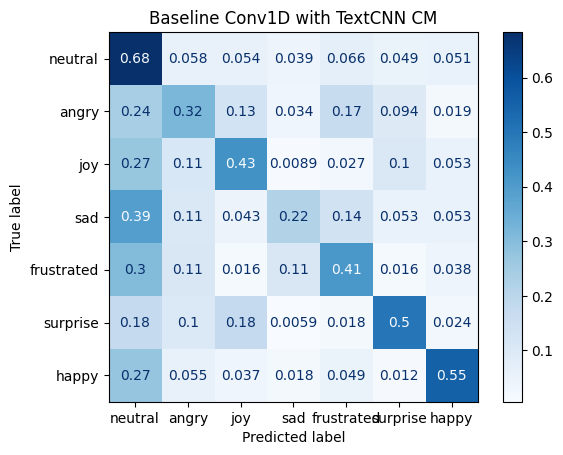

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_base_fs, labels_list, "Baseline Conv1D with TextCNN CM")

## Baseline Conv1D with BERT Model Fusion

Fusion of the Audio Conv1D BatchNorm + BERT Models

In [ ]:
# BERT input layer
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# create the fusion model
base_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], audio_conv1d_base_model, audio_input, len_labels)

# compile the model
base_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

base_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_base_bert = base_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 238s 395ms/step - loss: 1.8222 - accuracy: 0.3913 - val_loss: 1.7326 - val_accuracy: 0.4236 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 197s 392ms/step - loss: 1.5899 - accuracy: 0.4381 - val_loss: 1.5808 - val_accuracy: 0.4335 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 197s 391ms/step - loss: 1.4359 - accuracy: 0.4747 - val_loss: 1.5526 - val_accuracy: 0.4965 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 197s 391ms/step - loss: 1.3186 - accuracy: 0.5128 - val_loss: 1.5221 - val_accuracy: 0.5149 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 197s 391ms/step - loss: 1.2424 - accuracy: 0.5249 - val_loss: 1.5223 - val_accuracy: 0.5466 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 197s 392ms/step - loss: 1.1920 - accuracy: 0.5368 - val_loss: 1.4985 - val_accuracy: 0.5164 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# predict on test data
y_pred_bert_base = base_bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred_bert_base = np.argmax(y_pred_bert_base, axis=1)

# print the model results
print(classification_report(test_labels, y_pred_bert_base, target_names=labels_list, zero_division=0))

63/63 [==============================] - 7s 115ms/step
              precision    recall  f1-score   support

     neutral       0.69      0.69      0.69       799
       angry       0.43      0.55      0.48       266
         joy       0.47      0.52      0.49       225
         sad       0.47      0.23      0.31       207
  frustrated       0.41      0.39      0.40       185
    surprise       0.55      0.58      0.57       170
       happy       0.56      0.57      0.56       164

    accuracy                           0.56      2016
   macro avg       0.51      0.51      0.50      2016
weighted avg       0.56      0.56      0.56      2016



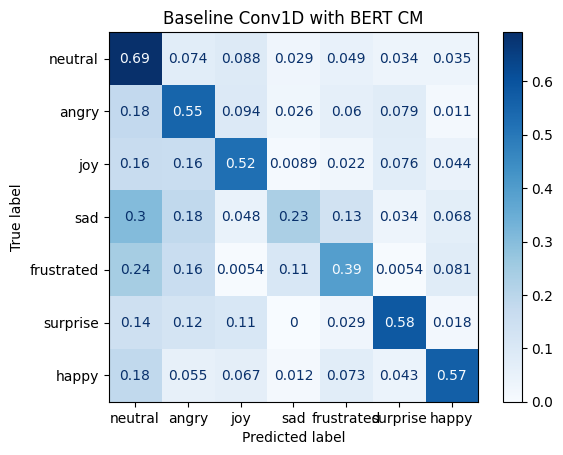

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_bert_base, labels_list, "Baseline Conv1D with BERT CM")

In [ ]:
base_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/bert_base_fusion_model.keras')

In [ ]:
base_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/bert_base_fusion_model.keras')

## Conv1D BatchNorm with TextCNN

Fusion of the Audio Conv1D BatchNorm + TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_batchnorm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioBatchNormInput')

# create the fusion model
batchnorm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, cnn_batchnorm, audio_batchnorm_input, len_labels)

# compile the model
batchnorm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

batchnorm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioBatchNormInput (Input  [(None, 143, 1)]             0         []                            
 Layer)                                                                                           
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    1554887   ['AudioBatchNormInput[0][0]'] 
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

In [ ]:
# Train the model
h_batchnorm = batchnorm_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 22s 31ms/step - loss: 1.8171 - accuracy: 0.3962 - val_loss: 1.7301 - val_accuracy: 0.3998 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 8s 15ms/step - loss: 1.5761 - accuracy: 0.4409 - val_loss: 1.5748 - val_accuracy: 0.4335 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 8s 15ms/step - loss: 1.3763 - accuracy: 0.5018 - val_loss: 1.5072 - val_accuracy: 0.5050 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 7s 14ms/step - loss: 1.2191 - accuracy: 0.5276 - val_loss: 1.4906 - val_accuracy: 0.5238 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 7s 15ms/step - loss: 1.1001 - accuracy: 0.5337 - val_loss: 1.4805 - val_accuracy: 0.5258 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 7s 14ms/step - loss: 1.0228 - accuracy: 0.5443 - val_loss: 1.4846 - val_accuracy: 0.5238 - lr: 2.0000e-05
Epoch 7/10
504/504 [===================

In [ ]:
# predict on test data
y_pred_batch_textcnn = batchnorm_fusion_model.predict([test_inputs, X_test_1d])
y_pred_batch_textcnn = np.argmax(y_pred_batch_textcnn, axis=1)

# print the model performance
print(classification_report(test_labels, y_pred_batch_textcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     neutral       0.61      0.72      0.66       799
       angry       0.39      0.36      0.37       266
         joy       0.41      0.43      0.42       225
         sad       0.35      0.29      0.32       207
  frustrated       0.48      0.30      0.37       185
    surprise       0.50      0.49      0.50       170
       happy       0.59      0.52      0.56       164

    accuracy                           0.52      2016
   macro avg       0.48      0.45      0.46      2016
weighted avg       0.51      0.52      0.51      2016



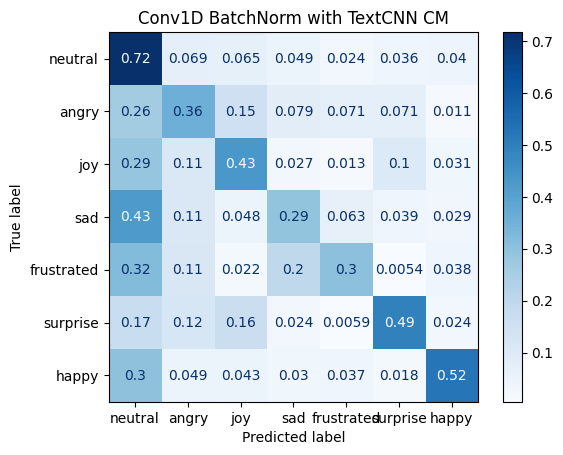

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_batch_textcnn, labels_list, "Conv1D BatchNorm with TextCNN CM")

In [ ]:
# Save the model weights to be re-used later if needed
batchnorm_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/batchnorm_fusion_model.keras')

In [ ]:
batchnorm_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/batchnorm_fusion_model.keras')

## Conv1D BatchNorm with BERT

Fusion of the Audio Conv1D BatchNorm + BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_batchnorm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioBatchNormInput')

# create the fusion model
batchn_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], cnn_batchnorm, audio_batchnorm_input, len_labels)

# compile the model
batchn_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

batchn_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioBatchNormInput (Input  [(None, 143, 1)]             0         []                            
 Layer)                                                                                           
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_cnnbn_bert = batchn_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 242s 399ms/step - loss: 1.8234 - accuracy: 0.3500 - val_loss: 1.6941 - val_accuracy: 0.4385 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 200s 396ms/step - loss: 1.5291 - accuracy: 0.4478 - val_loss: 1.5573 - val_accuracy: 0.4340 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 200s 396ms/step - loss: 1.3941 - accuracy: 0.4887 - val_loss: 1.5215 - val_accuracy: 0.4945 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 199s 396ms/step - loss: 1.2913 - accuracy: 0.4928 - val_loss: 1.4914 - val_accuracy: 0.4928 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 200s 396ms/step - loss: 1.1918 - accuracy: 0.5163 - val_loss: 1.4766 - val_accuracy: 0.5118 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 200s 396ms/step - loss: 1.1141 - accuracy: 0.5005 - val_loss: 1.4616 - val_accuracy: 0.5217 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# predict the values using the test values
y_pred_batch_bert = batchn_bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred_batch_bert = np.argmax(y_pred_batch_bert, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_batch_bert, target_names=labels_list, zero_division=0))

63/63 [==============================] - 9s 116ms/step
              precision    recall  f1-score   support

     neutral       0.67      0.73      0.69       799
       angry       0.38      0.46      0.41       266
         joy       0.51      0.52      0.51       225
         sad       0.33      0.39      0.36       207
  frustrated       0.50      0.35      0.41       185
    surprise       0.42      0.16      0.24       170
       happy       0.55      0.52      0.54       164

    accuracy                           0.53      2016
   macro avg       0.48      0.45      0.45      2016
weighted avg       0.53      0.53      0.53      2016



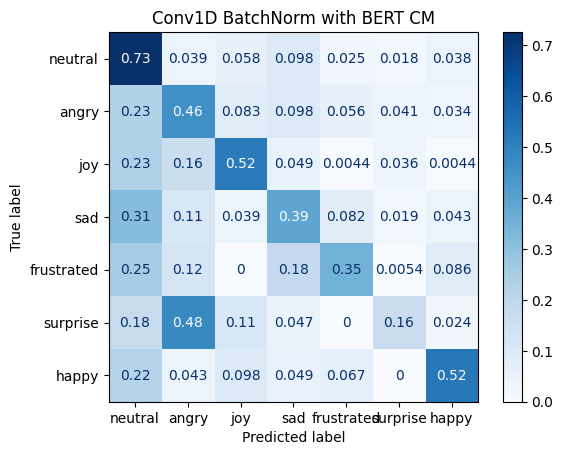

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_batch_bert, labels_list, "Conv1D BatchNorm with BERT CM")

In [ ]:
# Save the model weights to be re-used later if needed
batchn_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/batchn_bert_fusion.keras')

In [ ]:
batchn_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/batchn_bert_fusion.keras')

## Conv1D Bi-LSTM with TextCNN

Fusion of the Audio Conv1D Bidirectional LSTM + TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioConv1DLSTMInput')

# create the fusion model
c1d_lstm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv1d_lstm_model, audio_input, len_labels)

# compile the model
c1d_lstm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c1d_lstm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv1DLSTMInput (Inpu  [(None, 143, 1)]             0         []                            
 tLayer)                                                                                          
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 7)                    912903    ['AudioConv1DLSTMInput[0][0]']
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

In [ ]:
# Train the model
h_c1d_lstm = c1d_lstm_fusion_model.fit(
    [train_inputs, X_train_1d],
    train_labels,
    validation_data=([val_inputs, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 24s 31ms/step - loss: 1.7491 - accuracy: 0.3943 - val_loss: 1.6605 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 1.4868 - accuracy: 0.4060 - val_loss: 1.5718 - val_accuracy: 0.3988 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 7s 13ms/step - loss: 1.3178 - accuracy: 0.5242 - val_loss: 1.5483 - val_accuracy: 0.5243 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 6s 13ms/step - loss: 1.1878 - accuracy: 0.5105 - val_loss: 1.5490 - val_accuracy: 0.5154 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 6s 13ms/step - loss: 1.0881 - accuracy: 0.4941 - val_loss: 1.5562 - val_accuracy: 0.5174 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 6s 13ms/step - loss: 1.0095 - accuracy: 0.5087 - val_loss: 1.5801 - val_accuracy: 0.5134 - lr: 2.0000e-05
Epoch 7/10
504/504 [===================

In [ ]:
# predict the values using the test values
y_pred_c1d_lstm_tcnn = c1d_lstm_fusion_model.predict([test_inputs, X_test_1d])
y_pred_c1d_lstm_tcnn = np.argmax(y_pred_c1d_lstm_tcnn, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c1d_lstm_tcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     neutral       0.66      0.42      0.51       799
       angry       0.46      0.44      0.45       266
         joy       0.40      0.52      0.45       225
         sad       0.32      0.39      0.35       207
  frustrated       0.38      0.54      0.44       185
    surprise       0.44      0.59      0.50       170
       happy       0.44      0.61      0.51       164

    accuracy                           0.47      2016
   macro avg       0.44      0.50      0.46      2016
weighted avg       0.51      0.47      0.47      2016



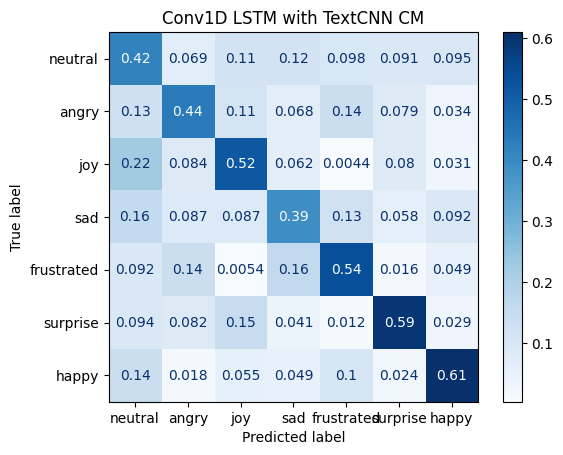

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c1d_lstm_tcnn, labels_list, "Conv1D LSTM with TextCNN CM")

In [ ]:
# predict the values using the test values
y_pred_c1d_lstm_tcnn = c1d_lstm_fusion_model.predict([test_inputs, X_test_1d])
y_pred_c1d_lstm_tcnn = np.argmax(y_pred_c1d_lstm_tcnn, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c1d_lstm_tcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

     neutral       0.62      0.67      0.65       799
       angry       0.36      0.32      0.34       266
         joy       0.42      0.41      0.42       225
         sad       0.18      0.08      0.11       207
  frustrated       0.33      0.44      0.38       185
    surprise       0.48      0.52      0.50       170
       happy       0.51      0.57      0.53       164

    accuracy                           0.49      2016
   macro avg       0.42      0.43      0.42      2016
weighted avg       0.47      0.49      0.48      2016



In [ ]:
# Save the model weights to be re-used later if needed
c1d_lstm_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c1d_lstm_fusion_weight.keras')

In [ ]:
c1d_lstm_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c1d_lstm_fusion_weight.keras')

## Conv1D Bi-LSTM with BERT

Fusion of the Audio Conv1D Bidirectional LSTM + BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_lstm_input = Input(shape=(X_train_1d.shape[1], 1), name='AudioConv1DLSTMInput')

# create the fusion model
c1dlstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv1d_lstm_model, audio_lstm_input, len_labels)

# compile the model
c1dlstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c1dlstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv1DLSTMInput (Inpu  [(None, 143, 1)]             0         []                            
 tLayer)                                                                                          
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_c1dlstm_bert = c1dlstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_1d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
504/504 [==============================] - 244s 401ms/step - loss: 1.7597 - accuracy: 0.3968 - val_loss: 1.6729 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 199s 395ms/step - loss: 1.5435 - accuracy: 0.4128 - val_loss: 1.5629 - val_accuracy: 0.4360 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 199s 395ms/step - loss: 1.4232 - accuracy: 0.4726 - val_loss: 1.5496 - val_accuracy: 0.4593 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 200s 396ms/step - loss: 1.3312 - accuracy: 0.5011 - val_loss: 1.4841 - val_accuracy: 0.5040 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 199s 395ms/step - loss: 1.2317 - accuracy: 0.5049 - val_loss: 1.4835 - val_accuracy: 0.5154 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 199s 396ms/step - loss: 1.1832 - accuracy: 0.5348 - val_loss: 1.4566 - val_accuracy: 0.5253 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# predict the values using the test values
y_pred_c1dlstm_bert = c1dlstm_bert_fusion_model.predict([test_inputs, test_masks, X_test_1d])
y_pred_c1dlstm_bert = np.argmax(y_pred_c1dlstm_bert, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c1dlstm_bert, target_names=labels_list, zero_division=0))

63/63 [==============================] - 7s 117ms/step
              precision    recall  f1-score   support

     neutral       0.67      0.64      0.65       799
       angry       0.26      0.61      0.36       266
         joy       0.31      0.57      0.41       225
         sad       0.30      0.14      0.20       207
  frustrated       0.49      0.15      0.23       185
    surprise       1.00      0.01      0.01       170
       happy       0.59      0.21      0.31       164

    accuracy                           0.44      2016
   macro avg       0.52      0.33      0.31      2016
weighted avg       0.54      0.44      0.42      2016



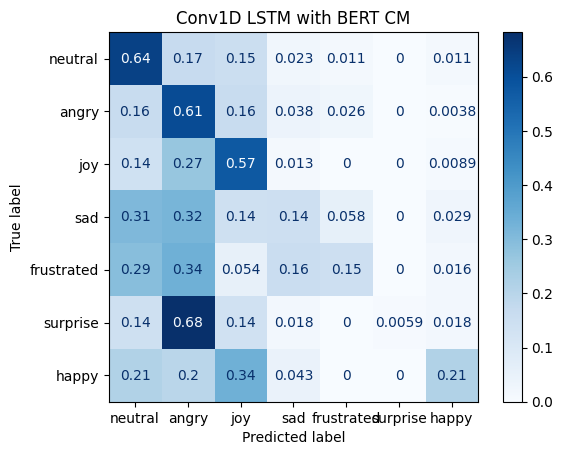

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c1dlstm_bert, labels_list, "Conv1D LSTM with BERT CM")

In [ ]:
# Save the model weights to be re-used later if needed
c1dlstm_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c1dlstm_bert_fusion_model_weight.keras')

In [ ]:
c1dlstm_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c1dlstm_bert_fusion_model_weight.keras')

## Conv2D with TextCNN

Fusion of the Audio Conv2D + TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DInput')

# create the fusion model
c2d_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv2d_model, audio_input, len_labels)

# compile the model
c2d_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c2d_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DInput (InputLay  [(None, 400, 162, 1)]        0         []                            
 er)                                                                                              
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 7)                    1338567   ['AudioConv2DInput[0][0]']    
                                                                                                  
 BaselineTextCNN (Sequentia  (None, 7)                    8185031   ['TextCNNInput[0

In [ ]:
# Train the model
h_c2d_textcnn = c2d_fusion_model.fit(
    [train_inputs, X_train_2d],
    train_labels,
    validation_data=([val_inputs, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 141s 129ms/step - loss: 1.8195 - accuracy: 0.3864 - val_loss: 1.7691 - val_accuracy: 0.4851 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.5171 - accuracy: 0.4210 - val_loss: 1.6047 - val_accuracy: 0.4777 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 124s 123ms/step - loss: 1.1751 - accuracy: 0.4747 - val_loss: 1.4615 - val_accuracy: 0.4960 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 124s 123ms/step - loss: 0.9299 - accuracy: 0.4970 - val_loss: 1.4741 - val_accuracy: 0.4931 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 124s 123ms/step - loss: 0.8023 - accuracy: 0.5121 - val_loss: 1.4767 - val_accuracy: 0.5064 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 124s 123ms/step - loss: 0.7509 - accuracy: 0.5230 - val_loss: 1.4908 - val_accuracy: 0.5134 - lr: 8.0000e-06
Epoch 7/10

In [ ]:
# predict the values using the test values
y_pred_c2d_textcnn = c2d_fusion_model.predict([test_inputs, X_test_2d])
y_pred_c2d_textcnn = np.argmax(y_pred_c2d_textcnn, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c2d_textcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 6s 30ms/step
              precision    recall  f1-score   support

     neutral       0.70      0.44      0.54       799
       angry       0.46      0.42      0.44       266
         joy       0.40      0.52      0.46       225
         sad       0.32      0.39      0.35       207
  frustrated       0.39      0.58      0.46       185
    surprise       0.44      0.58      0.50       170
       happy       0.48      0.65      0.55       164

    accuracy                           0.48      2016
   macro avg       0.46      0.51      0.47      2016
weighted avg       0.53      0.48      0.49      2016



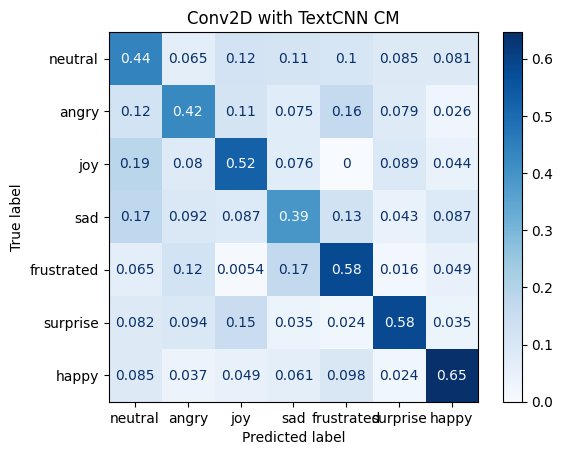

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_textcnn, labels_list, "Conv2D with TextCNN CM")

In [ ]:
# Train the model
h_c2d_textcnn = c2d_fusion_model.fit(
    [train_inputs, X_train_2d],
    train_labels,
    validation_data=([val_inputs, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 139s 134ms/step - loss: 1.7558 - accuracy: 0.3740 - val_loss: 1.6229 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 133s 132ms/step - loss: 1.4807 - accuracy: 0.4304 - val_loss: 1.5375 - val_accuracy: 0.4325 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.3441 - accuracy: 0.4897 - val_loss: 1.5259 - val_accuracy: 0.4623 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.2621 - accuracy: 0.4981 - val_loss: 1.5282 - val_accuracy: 0.4583 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.2065 - accuracy: 0.4962 - val_loss: 1.5239 - val_accuracy: 0.4762 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 132s 131ms/step - loss: 1.1650 - accuracy: 0.4918 - val_loss: 1.5396 - val_accuracy: 0.4807 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# predict the values using the test values
y_pred_c2d_textcnn = c2d_fusion_model.predict([test_inputs, X_test_2d])
y_pred_c2d_textcnn = np.argmax(y_pred_c2d_textcnn, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c2d_textcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

     neutral       0.65      0.72      0.68       799
       angry       0.39      0.23      0.29       266
         joy       0.29      0.56      0.38       225
         sad       0.37      0.36      0.36       207
  frustrated       0.43      0.48      0.45       185
    surprise       1.00      0.01      0.01       170
       happy       0.54      0.46      0.49       164

    accuracy                           0.50      2016
   macro avg       0.52      0.40      0.38      2016
weighted avg       0.55      0.50      0.47      2016



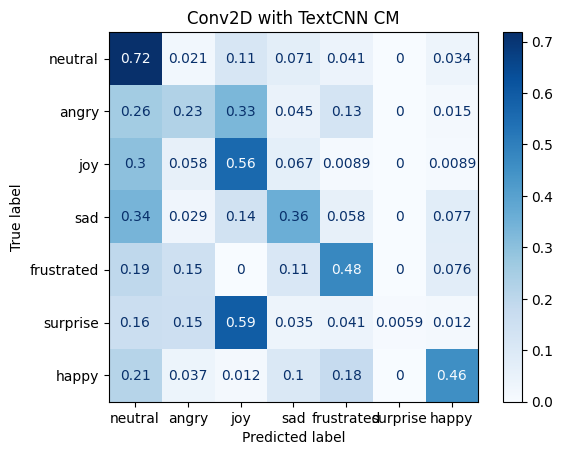

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_textcnn, labels_list, "Conv2D with TextCNN CM")

In [ ]:
# Save the model weights to be re-used later if needed
c2d_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c2d_fusion_model_weighted.keras')

In [ ]:
c2d_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c2d_fusion_model.keras')

## Conv2D with BERT

Fusion of the Audio Conv2D + BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DInput')

# create the fusion model
c2d_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_model, audio_input, len_labels)

# compile the model
c2d_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c2d_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DInput (InputLay  [(None, 400, 162, 1)]        0         []                            
 er)                                                                                              
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_c2d_bert = c2d_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 380s 337ms/step - loss: 1.7636 - accuracy: 0.3908 - val_loss: 1.6406 - val_accuracy: 0.4043 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 334s 332ms/step - loss: 1.5593 - accuracy: 0.4422 - val_loss: 1.5341 - val_accuracy: 0.4385 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 334s 331ms/step - loss: 1.4354 - accuracy: 0.4896 - val_loss: 1.4812 - val_accuracy: 0.4668 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 333s 331ms/step - loss: 1.3705 - accuracy: 0.5189 - val_loss: 1.5127 - val_accuracy: 0.3899 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 334s 331ms/step - loss: 1.2752 - accuracy: 0.5452 - val_loss: 1.3746 - val_accuracy: 0.5471 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 333s 331ms/step - loss: 1.1424 - accuracy: 0.5672 - val_loss: 1.3321 - val_accuracy: 0.5655 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# predict using the test dataset
y_pred_c2d_bert = c2d_bert_fusion_model.predict([test_inputs, test_masks, X_test_2d])
y_pred_c2d_bert = np.argmax(y_pred_c2d_bert, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c2d_bert, target_names=labels_list, zero_division=0))

63/63 [==============================] - 11s 143ms/step
              precision    recall  f1-score   support

     neutral       0.68      0.73      0.70       799
       angry       0.44      0.33      0.38       266
         joy       0.57      0.49      0.53       225
         sad       0.45      0.43      0.44       207
  frustrated       0.42      0.59      0.49       185
    surprise       0.52      0.56      0.54       170
       happy       0.68      0.49      0.57       164

    accuracy                           0.57      2016
   macro avg       0.54      0.52      0.52      2016
weighted avg       0.57      0.57      0.57      2016



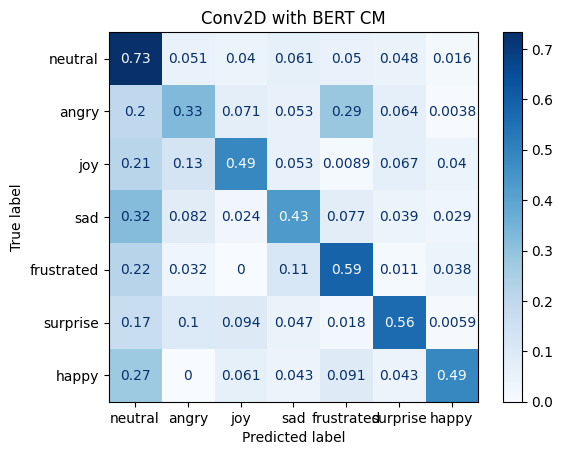

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_bert, labels_list, "Conv2D with BERT CM")

In [ ]:
# Save the model weights to be re-used later if needed
c2d_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c2d_bert_fusion_model_weight.keras')

In [ ]:
c2d_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c2d_bert_fusion_model.keras')

## Conv2D Bi-LSTM with TextCNN

Fusion of the Audio Conv2D Bi-LSTM + TextCNN

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
c2d_bilstm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv2d_lstm_model, audio_input, len_labels)

# compile the model
c2d_bilstm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c2d_bilstm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    5710215   ['AudioConv2DBiLSTMInput[0][0]
                                                                    ']                            
                                                                                    

In [ ]:
# Train the model
h_c2d_bilstm_textcnn = c2d_bilstm_fusion_model.fit(
    [train_inputs, X_train_2d],
    train_labels,
    validation_data=([val_inputs, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 134s 125ms/step - loss: 1.8328 - accuracy: 0.3041 - val_loss: 1.7214 - val_accuracy: 0.5585 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.5586 - accuracy: 0.4870 - val_loss: 1.4746 - val_accuracy: 0.6409 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.2636 - accuracy: 0.5741 - val_loss: 1.2906 - val_accuracy: 0.6171 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 123s 122ms/step - loss: 1.0443 - accuracy: 0.6376 - val_loss: 1.1426 - val_accuracy: 0.6434 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 123s 122ms/step - loss: 0.9239 - accuracy: 0.6623 - val_loss: 1.0611 - val_accuracy: 0.6662 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 123s 122ms/step - loss: 0.8624 - accuracy: 0.6770 - val_loss: 1.0166 - val_accuracy: 0.6696 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# predict the results using the test dataset
y_predc2d_bilstm_textcnn = c2d_bilstm_fusion_model.predict([test_inputs, X_test_2d])
y_predc2d_bilstm_textcnn = np.argmax(y_predc2d_bilstm_textcnn, axis=1)

# print models performance
print(classification_report(test_labels, y_predc2d_bilstm_textcnn, target_names=labels_list, zero_division=0))

63/63 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

     neutral       0.76      0.73      0.74       799
       angry       0.68      0.59      0.63       266
         joy       0.65      0.76      0.70       225
         sad       0.64      0.64      0.64       207
  frustrated       0.60      0.64      0.62       185
    surprise       0.65      0.78      0.71       170
       happy       0.78      0.68      0.73       164

    accuracy                           0.70      2016
   macro avg       0.68      0.69      0.68      2016
weighted avg       0.70      0.70      0.70      2016



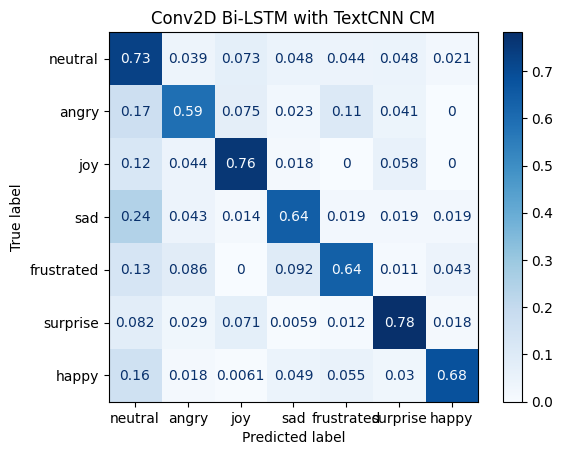

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_predc2d_bilstm_textcnn, labels_list, "Conv2D Bi-LSTM with TextCNN CM")

In [ ]:
# Save the model weights to be re-used later if needed
c2d_bilstm_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c2d_bilstm_fusion_model_weighted.keras')

In [ ]:
c2d_bilstm_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c2d_bilstm_fusion_model_weighted.keras')

## Conv2D Bi-LSTM with BERT

Fusion of the Audio Conv2D Bi-LSTM + BERT

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
c2d_lstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_lstm_model, audio_input, len_labels)

# compile the model
c2d_lstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

c2d_lstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_c2d_lstm_bert = c2d_lstm_bert_fusion_model.fit(
    [train_inputs, train_masks, X_train_2d],
    train_labels,
    validation_data=([val_inputs, val_masks, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 387s 338ms/step - loss: 1.8455 - accuracy: 0.3066 - val_loss: 1.7170 - val_accuracy: 0.4534 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.6218 - accuracy: 0.4367 - val_loss: 1.5212 - val_accuracy: 0.4975 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.4099 - accuracy: 0.5044 - val_loss: 1.3964 - val_accuracy: 0.5585 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 331s 329ms/step - loss: 1.2572 - accuracy: 0.5433 - val_loss: 1.2673 - val_accuracy: 0.5799 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 331s 328ms/step - loss: 1.1608 - accuracy: 0.5681 - val_loss: 1.2677 - val_accuracy: 0.5868 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.1019 - accuracy: 0.5808 - val_loss: 1.2789 - val_accuracy: 0.5769 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# predict the values for the test dataset
y_pred_c2d_lstm_bert = c2d_lstm_bert_fusion_model.predict([test_inputs, test_masks, X_test_2d])
y_pred_c2d_lstm_bert = np.argmax(y_pred_c2d_lstm_bert, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_c2d_lstm_bert, target_names=labels_list, zero_division=0))

63/63 [==============================] - 9s 139ms/step
              precision    recall  f1-score   support

     neutral       0.72      0.64      0.68       799
       angry       0.64      0.62      0.63       266
         joy       0.67      0.68      0.68       225
         sad       0.35      0.50      0.41       207
  frustrated       0.59      0.58      0.58       185
    surprise       0.71      0.75      0.73       170
       happy       0.77      0.74      0.75       164

    accuracy                           0.64      2016
   macro avg       0.63      0.64      0.64      2016
weighted avg       0.66      0.64      0.65      2016



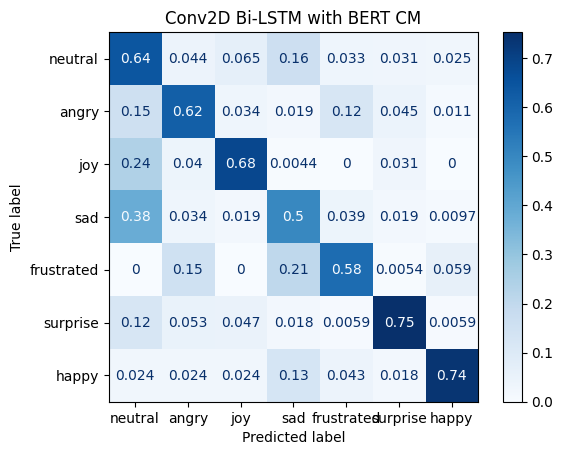

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_c2d_lstm_bert, labels_list, "Conv2D Bi-LSTM with BERT CM")

In [ ]:
# Save the model weights to be re-used later if needed
c2d_lstm_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/c2d_lstm_bert_fusion_model_weighted.keras')

In [ ]:
c2d_lstm_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/c2d_lstm_bert_fusion_model_weighted.keras')

## Wav2Vec2 TextCNN

Fusion of the pre-trained Wav2Vec2 Model utilising facebook/wav2vec2-base and TextCNN.

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
w2v2_inputs = {
        "input_features": Input(shape=(max_seq_len,),  dtype=tf.float32, name='Wav2Vec2InputFeatures'),
        "attention_mask": Input(shape=(max_seq_len,), dtype=tf.int32, name='Wav2Vec2AttentionMask')
    }
# create the fusion model
w2v2_textcnn_fusion_model = build_fusion_model(textcnn_model, textcnn_input, wav2vec2_mdl, w2v2_inputs, len_labels)

w2v2_textcnn_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Wav2Vec2AttentionMask (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 Wav2Vec2InputFeatures (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                    

In [ ]:
# compile the model
w2v2_textcnn_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_wav2vec2_textcnn = w2v2_textcnn_fusion_model.fit(
    [train_inputs, w2v2_train_x],
    train_labels,
    validation_data=([val_inputs, w2v2_val_x], val_labels),
    batch_size=8,
    epochs=4,
    # class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
2016/2016 [==============================] - 640s 290ms/step - loss: 1.8637 - accuracy: 0.3297 - val_loss: 1.8020 - val_accuracy: 0.4702 - lr: 1.0000e-05
Epoch 2/4
2016/2016 [==============================] - 569s 282ms/step - loss: 1.7299 - accuracy: 0.5072 - val_loss: 1.6919 - val_accuracy: 0.5010 - lr: 1.0000e-05
Epoch 3/4
2016/2016 [==============================] - 570s 283ms/step - loss: 1.5520 - accuracy: 0.5777 - val_loss: 1.5459 - val_accuracy: 0.5503 - lr: 1.0000e-05
Epoch 4/4
2016/2016 [==============================] - 569s 282ms/step - loss: 1.4380 - accuracy: 0.5853 - val_loss: 1.4859 - val_accuracy: 0.5724 - lr: 1.0000e-05


In [ ]:
# get the test results
y_pred_w2v2_textcnn = w2v2_textcnn_fusion_model.predict([test_inputs, w2v2_test_x])
y_pred_w2v2_textcnn = np.argmax(y_pred_w2v2_textcnn, axis=1)

# print results from the classifier
print(classification_report(test_labels, y_pred_w2v2_textcnn, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 26s 272ms/step
              precision    recall  f1-score   support

     neutral       0.70      0.66      0.68       799
       angry       0.56      0.21      0.30       266
         joy       0.43      0.55      0.48       225
         sad       0.48      0.41      0.44       207
  frustrated       0.40      0.78      0.53       185
    surprise       0.54      0.58      0.56       170
       happy       0.65      0.64      0.65       164

    accuracy                           0.56      2016
   macro avg       0.54      0.55      0.52      2016
weighted avg       0.58      0.56      0.56      2016



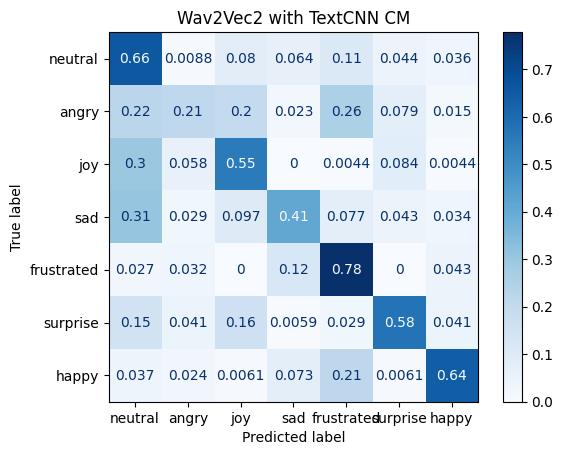

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(test_labels, y_pred_w2v2_textcnn, labels_list, "Wav2Vec2 with TextCNN CM")

In [ ]:
# Save the model to be re-used later if needed
w2v2_textcnn_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/w2v2_textcnn_fusion_model.keras')

In [ ]:
w2v2_textcnn_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/w2v2_textcnn_fusion_model.keras')

## Wav2Vec2 BERT

Fusion of the pre-trained Wav2Vec2 Model utilising facebook/wav2vec2-base and BERT.

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
w2v2_inputs = {
        "input_features": Input(shape=(max_seq_len,),  dtype=tf.float32, name='Wav2Vec2InputFeatures'),
        "attention_mask": Input(shape=(max_seq_len,), dtype=tf.int32, name='Wav2Vec2AttentionMask')
    }
# create the fusion model
w2v2_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], wav2vec2_mdl, w2v2_inputs, len_labels)

w2v2_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Wav2Vec2AttentionMask (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 Wav2Vec2InputFeatures (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                    

In [ ]:
# compile the model
w2v2_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-05, epsilon=1e-08),
    metrics=['accuracy']
)

In [ ]:
# Train the model
h_wav2vec2_bert = w2v2_bert_fusion_model.fit(
    [train_inputs, train_masks, w2v2_train_x],
    train_labels,
    validation_data=([val_inputs, val_masks, w2v2_val_x], val_labels),
    batch_size=16,
    epochs=4,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
1008/1008 [==============================] - 715s 616ms/step - loss: 1.7851 - accuracy: 0.4324 - val_loss: 1.6810 - val_accuracy: 0.4792 - lr: 1.0000e-05
Epoch 2/4
1008/1008 [==============================] - 614s 609ms/step - loss: 1.5192 - accuracy: 0.5267 - val_loss: 1.5362 - val_accuracy: 0.4931 - lr: 1.0000e-05
Epoch 3/4
1008/1008 [==============================] - 614s 609ms/step - loss: 1.3006 - accuracy: 0.5897 - val_loss: 1.4051 - val_accuracy: 0.5372 - lr: 1.0000e-05
Epoch 4/4
1008/1008 [==============================] - 614s 609ms/step - loss: 1.1092 - accuracy: 0.5926 - val_loss: 1.3639 - val_accuracy: 0.5650 - lr: 1.0000e-05


In [ ]:
# get the test results
y_pred_w2v2_bert = w2v2_bert_fusion_model.predict([test_inputs, test_masks, w2v2_test_x])
y_pred_w2v2_bert = np.argmax(y_pred_w2v2_bert, axis=1)

# print results from the classifier
print(classification_report(test_labels, y_pred_w2v2_bert, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 15s 235ms/step
              precision    recall  f1-score   support

     neutral       0.70      0.70      0.70       799
       angry       0.46      0.54      0.49       266
         joy       0.40      0.50      0.44       225
         sad       0.46      0.46      0.46       207
  frustrated       0.48      0.43      0.45       185
    surprise       0.60      0.48      0.53       170
       happy       0.82      0.53      0.64       164

    accuracy                           0.57      2016
   macro avg       0.56      0.52      0.53      2016
weighted avg       0.59      0.57      0.58      2016



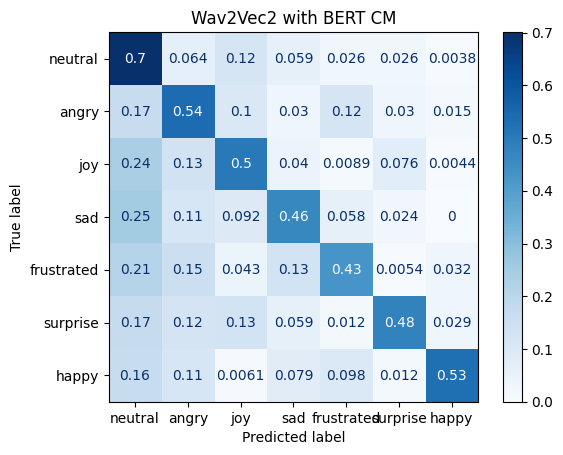

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(test_labels, y_pred_w2v2_bert, labels_list, "Wav2Vec2 with BERT CM")

In [ ]:
# Save the model to be re-used later if needed
w2v2_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/wav2vec2_bert_fusion.keras')

In [ ]:
# Save the model to be re-used later if needed
w2v2_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/wav2vec2_bert_fusion.keras')

# Model fusion utilising ASR (automatic speech recognition) transcriptions

Using transcripts from Automatic Speech Recognition (ASR), we further assess the performance of the top-performing models found in the preceding section. As transcriptions of text data aren't always easily accessible, ASR allows the generation of the necessary transcripts, enabling us to evaluate the models' effectiveness using transcripts produced by ASR in addition to the original text data.

## ASR Baseline Conv1D with BERT Model Fusion

Fusion of the best performing Conv1D model with BERT utilising ASR transcriptions.

In [ ]:
# BERT input layer
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_1d.shape[1], 1), name='BaseAudioInput')

# create the fusion model
asr_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], audio_conv1d_base_model, audio_input, len_labels)

# compile the model
asr_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

asr_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BaseAudioInput (InputLayer  [(None, 143, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_asr_base_bert = asr_bert_fusion_model.fit(
    [train_inputs_asr, train_masks_asr, X_train_1d],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr, X_val_1d], y_val_1d),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
504/504 [==============================] - 243s 397ms/step - loss: 1.8678 - accuracy: 0.3213 - val_loss: 1.7655 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
504/504 [==============================] - 198s 393ms/step - loss: 1.7308 - accuracy: 0.3973 - val_loss: 1.7089 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 3/10
504/504 [==============================] - 198s 393ms/step - loss: 1.6870 - accuracy: 0.3976 - val_loss: 1.6919 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 4/10
504/504 [==============================] - 198s 393ms/step - loss: 1.6597 - accuracy: 0.4037 - val_loss: 1.6769 - val_accuracy: 0.3958 - lr: 2.0000e-05
Epoch 5/10
504/504 [==============================] - 198s 394ms/step - loss: 1.6456 - accuracy: 0.4183 - val_loss: 1.6720 - val_accuracy: 0.4296 - lr: 2.0000e-05
Epoch 6/10
504/504 [==============================] - 198s 394ms/step - loss: 1.6080 - accuracy: 0.4408 - val_loss: 1.6836 - val_accuracy: 0.4201 - lr: 2.0000e-05
Epoch 7/10
504/504 [==

In [ ]:
# predict the values using the test dataset
y_pred_asr_c1d_bert = asr_bert_fusion_model.predict([test_inputs_asr, test_masks_asr, X_test_1d])
y_pred_asr_c1d_bert = np.argmax(y_pred_asr_c1d_bert, axis=1)

# print models performance
print(classification_report(test_labels, y_pred_asr_c1d_bert, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 7s 115ms/step
              precision    recall  f1-score   support

     neutral       0.51      0.75      0.61       799
       angry       0.29      0.49      0.37       266
         joy       0.21      0.23      0.22       225
         sad       0.32      0.23      0.27       207
  frustrated       1.00      0.00      0.00       185
    surprise       1.00      0.00      0.00       170
       happy       1.00      0.00      0.00       164

    accuracy                           0.41      2016
   macro avg       0.62      0.24      0.21      2016
weighted avg       0.56      0.41      0.34      2016



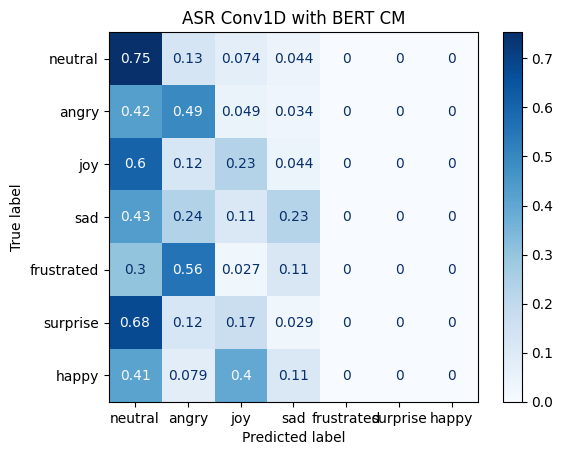

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr_c1d_bert, labels_list, "ASR Conv1D with BERT CM")

In [ ]:
# Save the model to be re-used later if needed
asr_bert_fusion_model.save('/content/drive/MyDrive/SavedModelWeights/asr_bert_fusion_model.keras')

In [ ]:
asr_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/asr_bert_fusion_model.keras')

## ASR Conv2D Bi-LSTM with TextCNN

Fusion of the Conv2D model Bi-LSTM with TextCNN utilising ASR transcriptions.

In [ ]:
# text cnn input layer
textcnn_input = Input(shape=(max_len), name='TextCNNInput')

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
asr_c2d_bilstm_fusion_model = build_fusion_model(textcnn_model, textcnn_input, conv2d_lstm_model, audio_input, len_labels)

# compile the model
asr_c2d_bilstm_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

asr_c2d_bilstm_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 TextCNNInput (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 7)                    5710215   ['AudioConv2DBiLSTMInput[0][0]
                                                                    ']                            
                                                                                    

In [ ]:
# Train the model
h_asr_c2d_bilstm_textcnn = asr_c2d_bilstm_fusion_model.fit(
    [train_inputs_asr, X_train_2d],
    train_labels,
    validation_data=([val_inputs_asr, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    # class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=4)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 142s 128ms/step - loss: 1.2102 - accuracy: 0.5531 - val_loss: 1.3043 - val_accuracy: 0.5089 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 122s 121ms/step - loss: 1.1773 - accuracy: 0.5700 - val_loss: 1.2965 - val_accuracy: 0.5124 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 122s 121ms/step - loss: 1.1453 - accuracy: 0.5829 - val_loss: 1.2946 - val_accuracy: 0.5169 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 122s 121ms/step - loss: 1.1252 - accuracy: 0.5936 - val_loss: 1.2941 - val_accuracy: 0.5144 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 122s 122ms/step - loss: 1.1009 - accuracy: 0.6029 - val_loss: 1.2845 - val_accuracy: 0.5159 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 122s 121ms/step - loss: 1.0760 - accuracy: 0.6158 - val_loss: 1.3023 - val_accuracy: 0.5119 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# print the results
y_pred_asr_c2d_bilstm_textcnn = asr_c2d_bilstm_fusion_model.predict([test_inputs_asr, X_test_2d])
y_pred_asr_c2d_bilstm_textcnn = np.argmax(y_pred_asr_c2d_bilstm_textcnn, axis=1)

# print the index to class and the algorithm performance
print(classification_report(test_labels, y_pred_asr_c2d_bilstm_textcnn, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

     neutral       0.54      0.70      0.61       799
       angry       0.49      0.31      0.38       266
         joy       0.37      0.26      0.31       225
         sad       0.49      0.46      0.48       207
  frustrated       0.55      0.50      0.52       185
    surprise       0.45      0.30      0.36       170
       happy       0.64      0.67      0.65       164

    accuracy                           0.52      2016
   macro avg       0.50      0.46      0.47      2016
weighted avg       0.51      0.52      0.51      2016



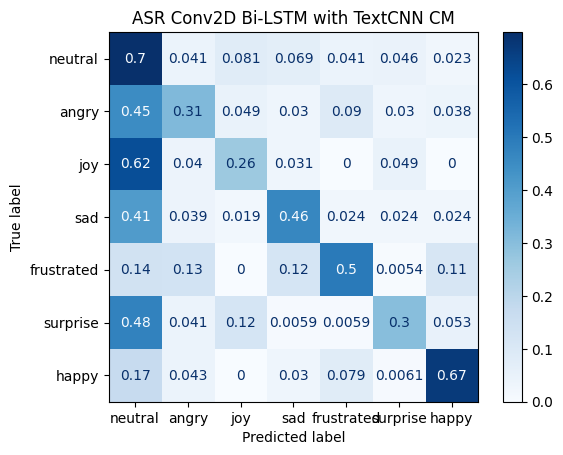

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr_c2d_bilstm_textcnn, labels_list, "ASR Conv2D Bi-LSTM with TextCNN CM")

In [ ]:
# Save the model to be re-used later if needed
asr_c2d_bilstm_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/asr_c2d_bilstm_fusion_model2.keras')

In [ ]:
asr_c2d_bilstm_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/asr_c2d_bilstm_fusion_model.keras')

## ASR Conv2D Bi-LSTM with BERT

Fusion of the best performing Conv2D model Bi-LSTM with BERT utilising ASR transcriptions.

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
audio_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], 1), name='AudioConv2DBiLSTMInput')

# create the fusion model
asr_c2d_lstm_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], conv2d_lstm_model, audio_input, len_labels)

# compile the model
asr_c2d_lstm_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=2e-05, epsilon=1e-08),
    metrics=['accuracy']
)

asr_c2d_lstm_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AudioConv2DBiLSTMInput (In  [(None, 400, 162, 1)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                                  
 BERTAttentionMasks (InputL  [(None, 180)]                0         []                            
 ayer)                                                                                            
                                                                                    

In [ ]:
# Train the model
h_asr_c2d_lstm_bert = asr_c2d_lstm_bert_fusion_model.fit(
    [train_inputs_asr, train_masks_asr, X_train_2d],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr, X_val_2d], val_labels),
    epochs=10,
    batch_size=16,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
1008/1008 [==============================] - 393s 341ms/step - loss: 1.7547 - accuracy: 0.3962 - val_loss: 1.7138 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 2/10
1008/1008 [==============================] - 333s 330ms/step - loss: 1.6875 - accuracy: 0.3981 - val_loss: 1.6747 - val_accuracy: 0.3968 - lr: 2.0000e-05
Epoch 3/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.6274 - accuracy: 0.4188 - val_loss: 1.6509 - val_accuracy: 0.4152 - lr: 2.0000e-05
Epoch 4/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.5881 - accuracy: 0.4351 - val_loss: 1.6102 - val_accuracy: 0.4216 - lr: 2.0000e-05
Epoch 5/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.5244 - accuracy: 0.4582 - val_loss: 1.5689 - val_accuracy: 0.4266 - lr: 2.0000e-05
Epoch 6/10
1008/1008 [==============================] - 332s 329ms/step - loss: 1.4765 - accuracy: 0.4726 - val_loss: 1.5593 - val_accuracy: 0.4271 - lr: 2.0000e-05
Epoch 7/10

In [ ]:
# print the results
y_pred_asr_c2d_lstm_bert = asr_c2d_lstm_bert_fusion_model.predict([test_inputs_asr, test_masks_asr, X_test_2d])
y_pred_asr_c2d_lstm_bert = np.argmax(y_pred_asr_c2d_lstm_bert, axis=1)

# print the index to class and the algorithm performance
print(classification_report(test_labels, y_pred_asr_c2d_lstm_bert, target_names=labels_list, zero_division=0.0))

63/63 [==============================] - 9s 140ms/step
              precision    recall  f1-score   support

     neutral       0.55      0.65      0.59       799
       angry       0.42      0.33      0.37       266
         joy       0.29      0.26      0.27       225
         sad       0.25      0.33      0.28       207
  frustrated       0.49      0.50      0.50       185
    surprise       0.29      0.09      0.14       170
       happy       0.61      0.50      0.55       164

    accuracy                           0.46      2016
   macro avg       0.41      0.38      0.39      2016
weighted avg       0.45      0.46      0.45      2016



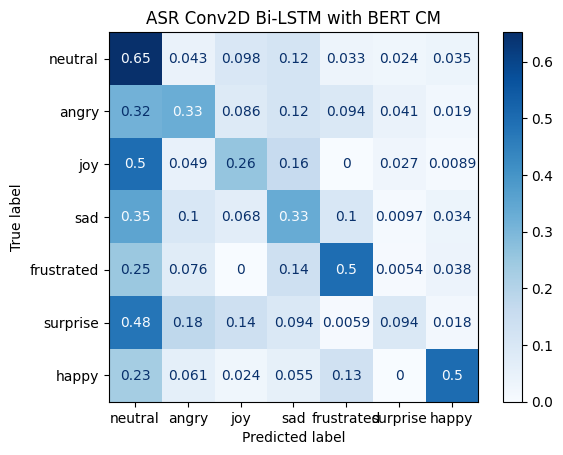

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr_c2d_lstm_bert, labels_list, "ASR Conv2D Bi-LSTM with BERT CM")

In [ ]:
# Save the model to be re-used later if needed
asr_c2d_lstm_bert_fusion_model.save('/content/drive/MyDrive/SavedModelWeights/asr_c2d_lstm_bert_fusion_model.keras')

In [ ]:
asr_c2d_lstm_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/asr_c2d_lstm_bert_fusion_model.keras')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


## ASR Wav2Vec2 with BERT

Fusion of the Wav2Vec2 model with BERT utilising ASR transcriptions.

In [ ]:
# BERT input layers
bert_input_ids = Input(shape=(max_len,), dtype=tf.int32, name='BERTInputIds') # input ids layer
bert_attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='BERTAttentionMasks') # attention masks layer

# audio input layer
w2v2_inputs = {
        "input_features": Input(shape=(max_seq_len,),  dtype=tf.float32, name='Wav2Vec2InputFeatures'),
        "attention_mask": Input(shape=(max_seq_len,), dtype=tf.int32, name='Wav2Vec2AttentionMask')
    }
# create the fusion model
asr_w2v2_bert_fusion_model = build_fusion_model(bert_model, [bert_input_ids,bert_attention_masks], wav2vec2_mdl, w2v2_inputs, len_labels)

# compile the model
asr_w2v2_bert_fusion_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-05, epsilon=1e-08),
    metrics=['accuracy']
)

asr_w2v2_bert_fusion_model.summary()

Model: "LateFusionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Wav2Vec2AttentionMask (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 Wav2Vec2InputFeatures (Inp  [(None, 80000)]              0         []                            
 utLayer)                                                                                         
                                                                                                  
 BERTInputIds (InputLayer)   [(None, 180)]                0         []                            
                                                                                    

In [ ]:
# Train the model
h_asr_wav2vec2 = asr_w2v2_bert_fusion_model.fit(
    [train_inputs_asr, train_masks_asr, w2v2_train_x],
    train_labels,
    validation_data=([val_inputs_asr, val_masks_asr, w2v2_val_x], val_labels),
    batch_size=16,
    epochs=4,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001),
        EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/4
1008/1008 [==============================] - 529s 438ms/step - loss: 1.8302 - accuracy: 0.3563 - val_loss: 1.7502 - val_accuracy: 0.4276 - lr: 1.0000e-05
Epoch 2/4
1008/1008 [==============================] - 433s 429ms/step - loss: 1.6243 - accuracy: 0.4691 - val_loss: 1.6251 - val_accuracy: 0.4692 - lr: 1.0000e-05
Epoch 3/4
1008/1008 [==============================] - 432s 429ms/step - loss: 1.4545 - accuracy: 0.5385 - val_loss: 1.5523 - val_accuracy: 0.4871 - lr: 1.0000e-05
Epoch 4/4
1008/1008 [==============================] - 432s 429ms/step - loss: 1.3124 - accuracy: 0.5529 - val_loss: 1.5061 - val_accuracy: 0.4931 - lr: 1.0000e-05


In [ ]:
# print the results
y_pred_asr_w2v2_bert = asr_w2v2_bert_fusion_model.predict([test_inputs_asr, test_masks_asr, w2v2_test_x])
y_pred_asr_w2v2_bert = np.argmax(y_pred_asr_w2v2_bert, axis=1)

# print the index to class and the algorithm performance
print(classification_report(test_labels, y_pred_asr_w2v2_bert, target_names=labels_list, zero_division=0))

63/63 [==============================] - 34s 389ms/step
              precision    recall  f1-score   support

     neutral       0.58      0.75      0.65       799
       angry       0.45      0.35      0.39       266
         joy       0.40      0.14      0.21       225
         sad       0.41      0.51      0.45       207
  frustrated       0.44      0.40      0.42       185
    surprise       0.39      0.31      0.35       170
       happy       0.64      0.52      0.57       164

    accuracy                           0.52      2016
   macro avg       0.47      0.42      0.43      2016
weighted avg       0.50      0.52      0.49      2016



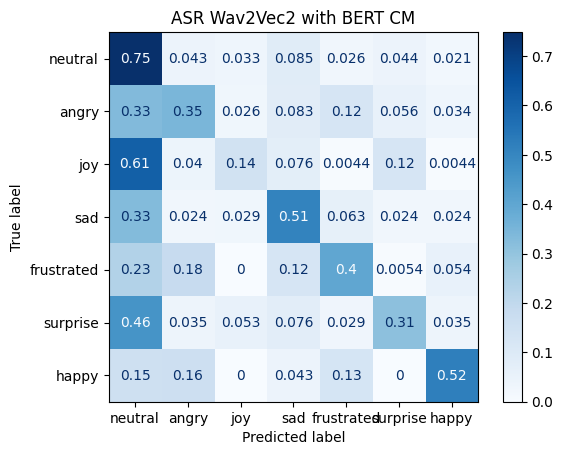

In [ ]:
# create the confusion matrix
plot_confusion_matrix(test_labels, y_pred_asr_w2v2_bert, labels_list, "ASR Wav2Vec2 with BERT CM")

In [ ]:
# Save the model to be re-used later if needed
asr_w2v2_bert_fusion_model.save_weights('/content/drive/MyDrive/SavedModelWeights/asr_wav2vec2_bert_fusion.keras')

In [ ]:
# Load the model
asr_w2v2_bert_fusion_model.load_weights('/content/drive/MyDrive/SavedModelWeights/asr_wav2vec2_bert_fusion.keras')